In [2]:
import pandas as pd
import numpy as np
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.layers import ReLU, GlobalAveragePooling1D
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

import seaborn as sns
import shutil
import re
from tqdm import tqdm

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
respeck_df = pd.read_csv('respeck_dataset.csv')

In [4]:
columns_of_interest_initial = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z','subject_id','activity_subtype', 'activity_type','recording_id']
#Subject id is of interest to us as we will split our dataset by subject_id
columns_of_interest_training = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
columns_of_accel_only = ['accel_x', 'accel_y', 'accel_z']

In [5]:
respeck_df = respeck_df.dropna(subset=columns_of_interest_initial).reset_index(drop=True)
respeck_df

,Unnamed: 0,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,subject_id,sensor_type,activity_type,activity_subtype,recording_id
0,0,1697605965,-0.637451,0.083435,0.928894,-1.609375,1.484375,2.812500,s61,respeck,lyingBack,talking,s61_respeck_lyingBack_talking
1,1,1697606005,-0.558594,0.105164,0.892029,-0.671875,5.515625,0.968750,s61,respeck,lyingBack,talking,s61_respeck_lyingBack_talking
2,2,1697606045,-0.513184,0.087830,0.914246,-0.421875,4.734375,2.015625,s61,respeck,lyingBack,talking,s61_respeck_lyingBack_talking
3,3,1697606085,-0.471436,0.101013,0.908630,-0.156250,1.843750,3.031250,s61,respeck,lyingBack,talking,s61_respeck_lyingBack_talking
4,4,1697606125,-0.485352,0.064880,0.916199,-1.421875,0.218750,2.828125,s61,respeck,lyingBack,talking,s61_respeck_lyingBack_talking
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347841,755,1697636165,-0.124268,-0.947327,0.106140,-1.328125,32.140625,-7.390625,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal
2347842,756,1697636205,0.016846,-1.116028,0.225525,0.703125,11.218750,-14.890625,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal
2347843,757,1697636245,0.047119,-1.000549,0.235291,-16.171875,21.750000,6.968750,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal
2347844,758,1697636285,-0.101074,-0.867249,0.209167,0.078125,25.250000,11.281250,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal


In [6]:
print(f"The data was collected using the sensors: {respeck_df.sensor_type.unique()}")
print(f"The data was collected for the activities: {respeck_df.activity_type.unique()}")
print(f"The data was collected for the sub-activities: {respeck_df.activity_subtype.unique()}")
print(f"The number of unique recordings is: {len(respeck_df.recording_id.unique())}")
print(f"The subject IDs in the recordings are: {len(respeck_df.subject_id.unique())}")

The data was collected using the sensors: ['respeck']
The data was collected for the activities: ['lyingBack' 'lyingLeft' 'lyingRight' 'standing' 'sitting' 'descending'
 'lyingStomach' 'ascending' 'normalWalking' 'miscMovement'
 'shuffleWalking' 'running']
The data was collected for the sub-activities: ['talking' 'hyperventilating' 'laughing' 'singing' 'eating'
 'breathingNormal' 'coughing']
The number of unique recordings is: 3096
The subject IDs in the recordings are: 71


In [7]:
df = respeck_df
df['activity_type'] = df['activity_type'].replace(['sitting', 'standing'], 'sitting/standing')
# df['recording_id'] = df['recording_id'].replace(['sitting', 'standing'], 'sitting/standing', regex=True)

In [8]:
df[df['activity_type'] =='sitting/standing']

,Unnamed: 0,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,subject_id,sensor_type,activity_type,activity_subtype,recording_id
3800,0,1697605965,0.007324,-0.951233,0.087585,1.656250,6.703125,7.453125,s61,respeck,sitting/standing,hyperventilating,s61_respeck_standing_hyperventilating
3801,1,1697606005,-0.027100,-1.007874,0.124695,0.671875,5.093750,4.218750,s61,respeck,sitting/standing,hyperventilating,s61_respeck_standing_hyperventilating
3802,2,1697606045,0.013428,-1.015442,0.086365,-3.562500,1.609375,-1.500000,s61,respeck,sitting/standing,hyperventilating,s61_respeck_standing_hyperventilating
3803,3,1697606085,0.026123,-0.998352,0.079773,-6.484375,2.875000,1.859375,s61,respeck,sitting/standing,hyperventilating,s61_respeck_standing_hyperventilating
3804,4,1697606125,0.031006,-0.983215,0.115417,-1.437500,2.281250,1.531250,s61,respeck,sitting/standing,hyperventilating,s61_respeck_standing_hyperventilating
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346321,755,1697636165,-0.408203,-0.773499,0.499939,-1.890625,1.078125,-0.484375,s33,respeck,sitting/standing,talking,s33_respeck_sitting_talking
2346322,756,1697636205,-0.405029,-0.769592,0.507263,-1.625000,0.437500,-0.609375,s33,respeck,sitting/standing,talking,s33_respeck_sitting_talking
2346323,757,1697636245,-0.403076,-0.767639,0.493591,-0.390625,-0.390625,0.437500,s33,respeck,sitting/standing,talking,s33_respeck_sitting_talking
2346324,758,1697636285,-0.408936,-0.761780,0.493835,0.328125,-0.984375,0.875000,s33,respeck,sitting/standing,talking,s33_respeck_sitting_talking


### Preprocessing outliers

**RobustScaler** scales data while being robust to outliers by using the median and interquartile range (IQR): <br>

$x_{\text{scaled}} = \frac{{x - Q2}}{{Q3 - Q1}}$  <br>

Where:
Q1 is the first quartile (25th percentile) of the data.
Q2 is the median (50th percentile) of the data.
Q3 is the third quartile (75th percentile) of the data.

In [9]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler = scaler.fit(df[columns_of_accel_only].values)
df.loc[:,columns_of_accel_only] = scaler.transform(df[columns_of_accel_only].to_numpy())

In [10]:
print(f"The data was collected using the sensors: {df.sensor_type.unique()}")
print(f"The data was collected for the activities: {df.activity_type.unique()}")
print(f"The data was collected for the sub-activities: {df.activity_subtype.unique()}")
print(f"The number of unique recordings is: {len(df.recording_id.unique())}")
print(f"The subject IDs in the recordings are: {len(df.subject_id.unique())}")

The data was collected using the sensors: ['respeck']
The data was collected for the activities: ['lyingBack' 'lyingLeft' 'lyingRight' 'sitting/standing' 'descending'
 'lyingStomach' 'ascending' 'normalWalking' 'miscMovement'
 'shuffleWalking' 'running']
The data was collected for the sub-activities: ['talking' 'hyperventilating' 'laughing' 'singing' 'eating'
 'breathingNormal' 'coughing']
The number of unique recordings is: 3096
The subject IDs in the recordings are: 71


### Tools functions

In [11]:
# Splitting data into sliding windows
def group_into_sliding_windows(df, window_size, step_size):

    window_number = 0 # start a counter at 0 to keep track of the window number

    all_overlapping_windows = []


    for rid, group in df.groupby("recording_id"):
        large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

   
        overlapping_windows = large_enough_windows[::step_size] 
        if overlapping_windows:
            for window in overlapping_windows:
                window.loc[:, 'window_id'] = window_number
                window_number += 1


            all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))
        
    final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)
    
    return final_sliding_windows


def generate_data_from_sliding_windows(final_sliding_windows):
    X= []
    y= []
    for window_id, group in final_sliding_windows.groupby('window_id'):

        shape = group[columns_of_accel_only].values.shape

        X.append(group[columns_of_accel_only].values )
        y.append(class_labels[group["activity_type"].values[0]])
    
    return X,y


def convert_values_to_numpy_array(X_train_regenerated, y_train_regenerated, X_test_regenerated, y_test_regenerated):
    
    # #Convert categorical variable (labels) into dummy/indicator variables (one-hot encoding)
    y_train = np.asarray(pd.get_dummies(y_train_regenerated), dtype=np.float32)
    y_test = np.asarray(pd.get_dummies(y_test_regenerated), dtype=np.float32)

    X_train = np.asarray(X_train_regenerated).astype('float32')
    X_test = np.asarray(X_test_regenerated).astype('float32')

    print(f"X_train shape = {X_train.shape}")
    print(f"y_train shape = {y_train.shape}")

    print(f"X_test shape = {X_test.shape}")
    print(f"y_test shape = {y_test.shape}")
    return X_train, y_train, X_test, y_test


# Print Model Report
def show_report(model, history):
    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(y_true_labels, y_pred_labels))
    print(class_labels)
          
    cm = confusion_matrix(y_true_labels,y_pred_labels)
    cm_normalised = np.around(cm / cm.astype(np.float).sum(axis=1) , decimals=2)
          
    fig, ax= plt.subplots(figsize=(25, 25))
    # sns.set(font_scale=1.2)
    sns.heatmap(cm_normalised, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(class_labels); ax.yaxis.set_ticklabels(class_labels);
    
    figure_1 = plt.figure(figsize=((10,5)))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
          
    figure_2 = plt.figure(figsize=((10,5)))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
# Save the weights
def save_tflite_model(model, filename, save_folder='./Models/'):
    filename = filename + ".tflite"
    # Convert the TensorFlow model to TFLite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Create the folder if it doesn't exist
    os.makedirs(save_folder, exist_ok=True)

    # Save the TFLite model to the specified folder
    tflite_filename = os.path.join(save_folder, filename)
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    print(f'TFLite model saved as "{filename}"')

# Task 1: Offline classification of general human activities using Respeck accelerometer only

### Grouping General Human Activities

In [12]:
phy_acts_df = df[respeck_df["activity_subtype"] == 'breathingNormal']

phy_acts_df.groupby("activity_type").size().reset_index(name="count")

,activity_type,count
0,ascending,52939
1,descending,51327
2,lyingBack,53902
3,lyingLeft,53802
4,lyingRight,53986
5,lyingStomach,53859
6,miscMovement,53125
7,normalWalking,53763
8,running,52977
9,shuffleWalking,52471


### Generate class labels

In [20]:
acts = sorted(phy_acts_df.activity_type.unique())
class_labels = {act: idx for idx, act in enumerate(acts)}
class_labels

{'ascending': 0,
 'descending': 1,
 'lyingBack': 2,
 'lyingLeft': 3,
 'lyingRight': 4,
 'lyingStomach': 5,
 'miscMovement': 6,
 'normalWalking': 7,
 'running': 8,
 'shuffleWalking': 9,
 'sitting/standing': 10}

In [21]:
phy_acts_df['activity_label'] = phy_acts_df['activity_type'].map(class_labels)
phy_acts_df

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,subject_id,sensor_type,activity_type,activity_subtype,recording_id,activity_label
7598,0,1697605965,0.264660,-0.559762,-0.015574,-21.093750,-17.390625,-4.968750,s61,respeck,descending,breathingNormal,s61_respeck_descending_breathingNormal,1
7599,1,1697606005,0.075841,-0.667929,-0.125137,-28.328125,-11.875000,-9.656250,s61,respeck,descending,breathingNormal,s61_respeck_descending_breathingNormal,1
7600,2,1697606045,0.274042,-0.919957,-0.187158,14.984375,13.015625,-5.250000,s61,respeck,descending,breathingNormal,s61_respeck_descending_breathingNormal,1
7601,3,1697606085,1.020328,-0.918605,0.153552,5.468750,9.437500,7.000000,s61,respeck,descending,breathingNormal,s61_respeck_descending_breathingNormal,1
7602,4,1697606125,1.179828,-1.478367,0.306831,-2.171875,-23.734375,16.984375,s61,respeck,descending,breathingNormal,s61_respeck_descending_breathingNormal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347841,755,1697636165,-0.099687,-0.766360,0.004372,-1.328125,32.140625,-7.390625,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal,9
2347842,756,1697636205,0.126271,-0.953218,0.137978,0.703125,11.218750,-14.890625,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal,9
2347843,757,1697636245,0.174746,-0.825311,0.148907,-16.171875,21.750000,6.968750,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal,9
2347844,758,1697636285,-0.062549,-0.677664,0.119672,0.078125,25.250000,11.281250,s33,respeck,shuffleWalking,breathingNormal,s33_respeck_shuffleWalking_breathingNormal,9


In [22]:
from sklearn.model_selection import LeaveOneGroupOut, GroupShuffleSplit

X_with_subject_id = phy_acts_df[columns_of_interest_initial].reset_index(drop=True)
y_with_subject_id = phy_acts_df['activity_label'].reset_index(drop=True)

In [23]:
# Split by subject id
# gss = GroupShuffleSplit(test_size=0.2, random_state=42)
# gss_generator = gss.split(X_with_subject_id, y_with_subject_id, groups=X_with_subject_id.subject_id)

logo = LeaveOneGroupOut()
logo_generator = logo.split(X_with_subject_id, y_with_subject_id, groups=X_with_subject_id.subject_id)

In [24]:
train_ix, test_ix = next(logo_generator)

X_train_df = X_with_subject_id.loc[train_ix]
X_test_df = X_with_subject_id.loc[test_ix]

y_train_df = y_with_subject_id.loc[train_ix]
y_test_df = y_with_subject_id.loc[test_ix]


print(X_test_df['activity_type'].unique())
print("Number of activities:", len(X_test_df['activity_type'].unique()))

#Check how many subject_ids are in each of training and test set
print(f"The subject IDs in the recordings are: {len(phy_acts_df.subject_id.unique())}")
print(f"The subject IDs in the training set are: {len(X_train_df.subject_id.unique())}")
print(f"The subject IDs in the test set are: {len(X_test_df.subject_id.unique())}")

print(f"Testing on subject id: {X_test_df.subject_id.unique()} ")

['lyingStomach' 'ascending' 'sitting/standing' 'normalWalking'
 'descending' 'running' 'shuffleWalking' 'lyingLeft' 'lyingRight'
 'lyingBack' 'miscMovement']
Number of activities: 11
The subject IDs in the recordings are: 71
The subject IDs in the training set are: 70
The subject IDs in the test set are: 1
Testing on subject id: ['s1'] 


In [25]:
window_size = 50 # Default value: 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # Default value: 25, this is 50% overlap (step_size=25, window_size=50)

X_train_sliding_windows = group_into_sliding_windows(X_train_df,window_size,step_size)
X_test_sliding_windows = group_into_sliding_windows(X_test_df,window_size,step_size)

In [26]:
X_train_generated, y_train_generated = generate_data_from_sliding_windows(X_train_sliding_windows)
X_test_generated, y_test_generated = generate_data_from_sliding_windows(X_test_sliding_windows)

In [27]:
# #Convert categorical variable (labels) into dummy/indicator variables (one-hot encoding)
X_train, y_train, X_test, y_test = convert_values_to_numpy_array(X_train_generated, y_train_generated, X_test_generated, y_test_generated)

X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)


### Hyperameters setup

In [28]:
batch_size = 64
epochs = 50

## CNN

Tutorial: [1D Convolutional Neural Network Models for Human Activity Recognition](https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/)

1D Conv Layers - which will work on 1D data, for example a single axis from one single sensor (accel, gyro or mag)

2D Conv Layers - suitable if the input data is in the form of an image


In [29]:
def CNN_model_v1(X_train, y_train, X_test, y_test):
    window_size = X_train.shape[1]
    n_features = X_train.shape[2]
    n_classes = len(class_labels)
    
    model = Sequential([
        # CNN layers for spatial feature extraction
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, n_features), padding='same'),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Flatten(),

        # Dense layers for final classification
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Increased neurons and added regularization
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Added regularization
        Dropout(0.3),
        Dense(n_classes, activation='softmax'),  # Output layer
    ])
    
    # Learning rate decay with Adam
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy'])
    
    print(f"Training on CNN Model v1:")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

    callbacks_list = [early_stopping, reduce_lr]

    history = model.fit(X_train, y_train,
        batch_size=batch_size, epochs=epochs, callbacks=callbacks_list,
        validation_data=(X_test, y_test),
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    print(f'Test accuracy: {test_accuracy *100:.2f}%%')
    
    return model, history

In [30]:
cnn_model_v1, cnn_model_v1_history = CNN_model_v1(X_train, y_train, X_test, y_test)

2024-01-17 23:23:56.111478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 23:23:56.112945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-17 23:23:56.113133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-17 23:23:56.113250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training on CNN Model v1:
Epoch 1/50


2024-01-17 23:23:57.781075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-01-17 23:23:58.120620: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fbef108de10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 23:23:58.120650: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-01-17 23:23:58.139925: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-17 23:23:58.312647: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


377/377 [==============================] - 8s 12ms/step - loss: 2.1643 - accuracy: 0.7075 - val_loss: 0.9059 - val_accuracy: 0.9023 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 4s 11ms/step - loss: 0.6921 - accuracy: 0.8598 - val_loss: 0.3129 - val_accuracy: 0.9483 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 4s 11ms/step - loss: 0.4662 - accuracy: 0.9034 - val_loss: 0.2670 - val_accuracy: 0.9511 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 4s 11ms/step - loss: 0.4018 - accuracy: 0.9151 - val_loss: 0.2108 - val_accuracy: 0.9540 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 4s 10ms/step - loss: 0.3698 - accuracy: 0.9232 - val_loss: 0.3064 - val_accuracy: 0.9425 - lr: 9.8035e-04
Epoch 6/50
377/377 [==============================] - 4s 11ms/step - loss: 0.3388 - accuracy: 0.9329 - val_loss: 0.2557 - val_accuracy: 0.9598 - lr: 9.7646e-04
Epoch 7/50
377/377 [==============================]

11/11 [==============================] - 0s 3ms/step
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.91      1.00      0.95        29
           2       0.97      1.00      0.98        29
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        29
           5       1.00      1.00      1.00        29
           6       1.00      0.62      0.77        29
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00        29
           9       0.81      1.00      0.89        29
          10       1.00      1.00      1.00        58

    accuracy                           0.97       348
   macro avg       0.97      0.97      0.96       348
weigh

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


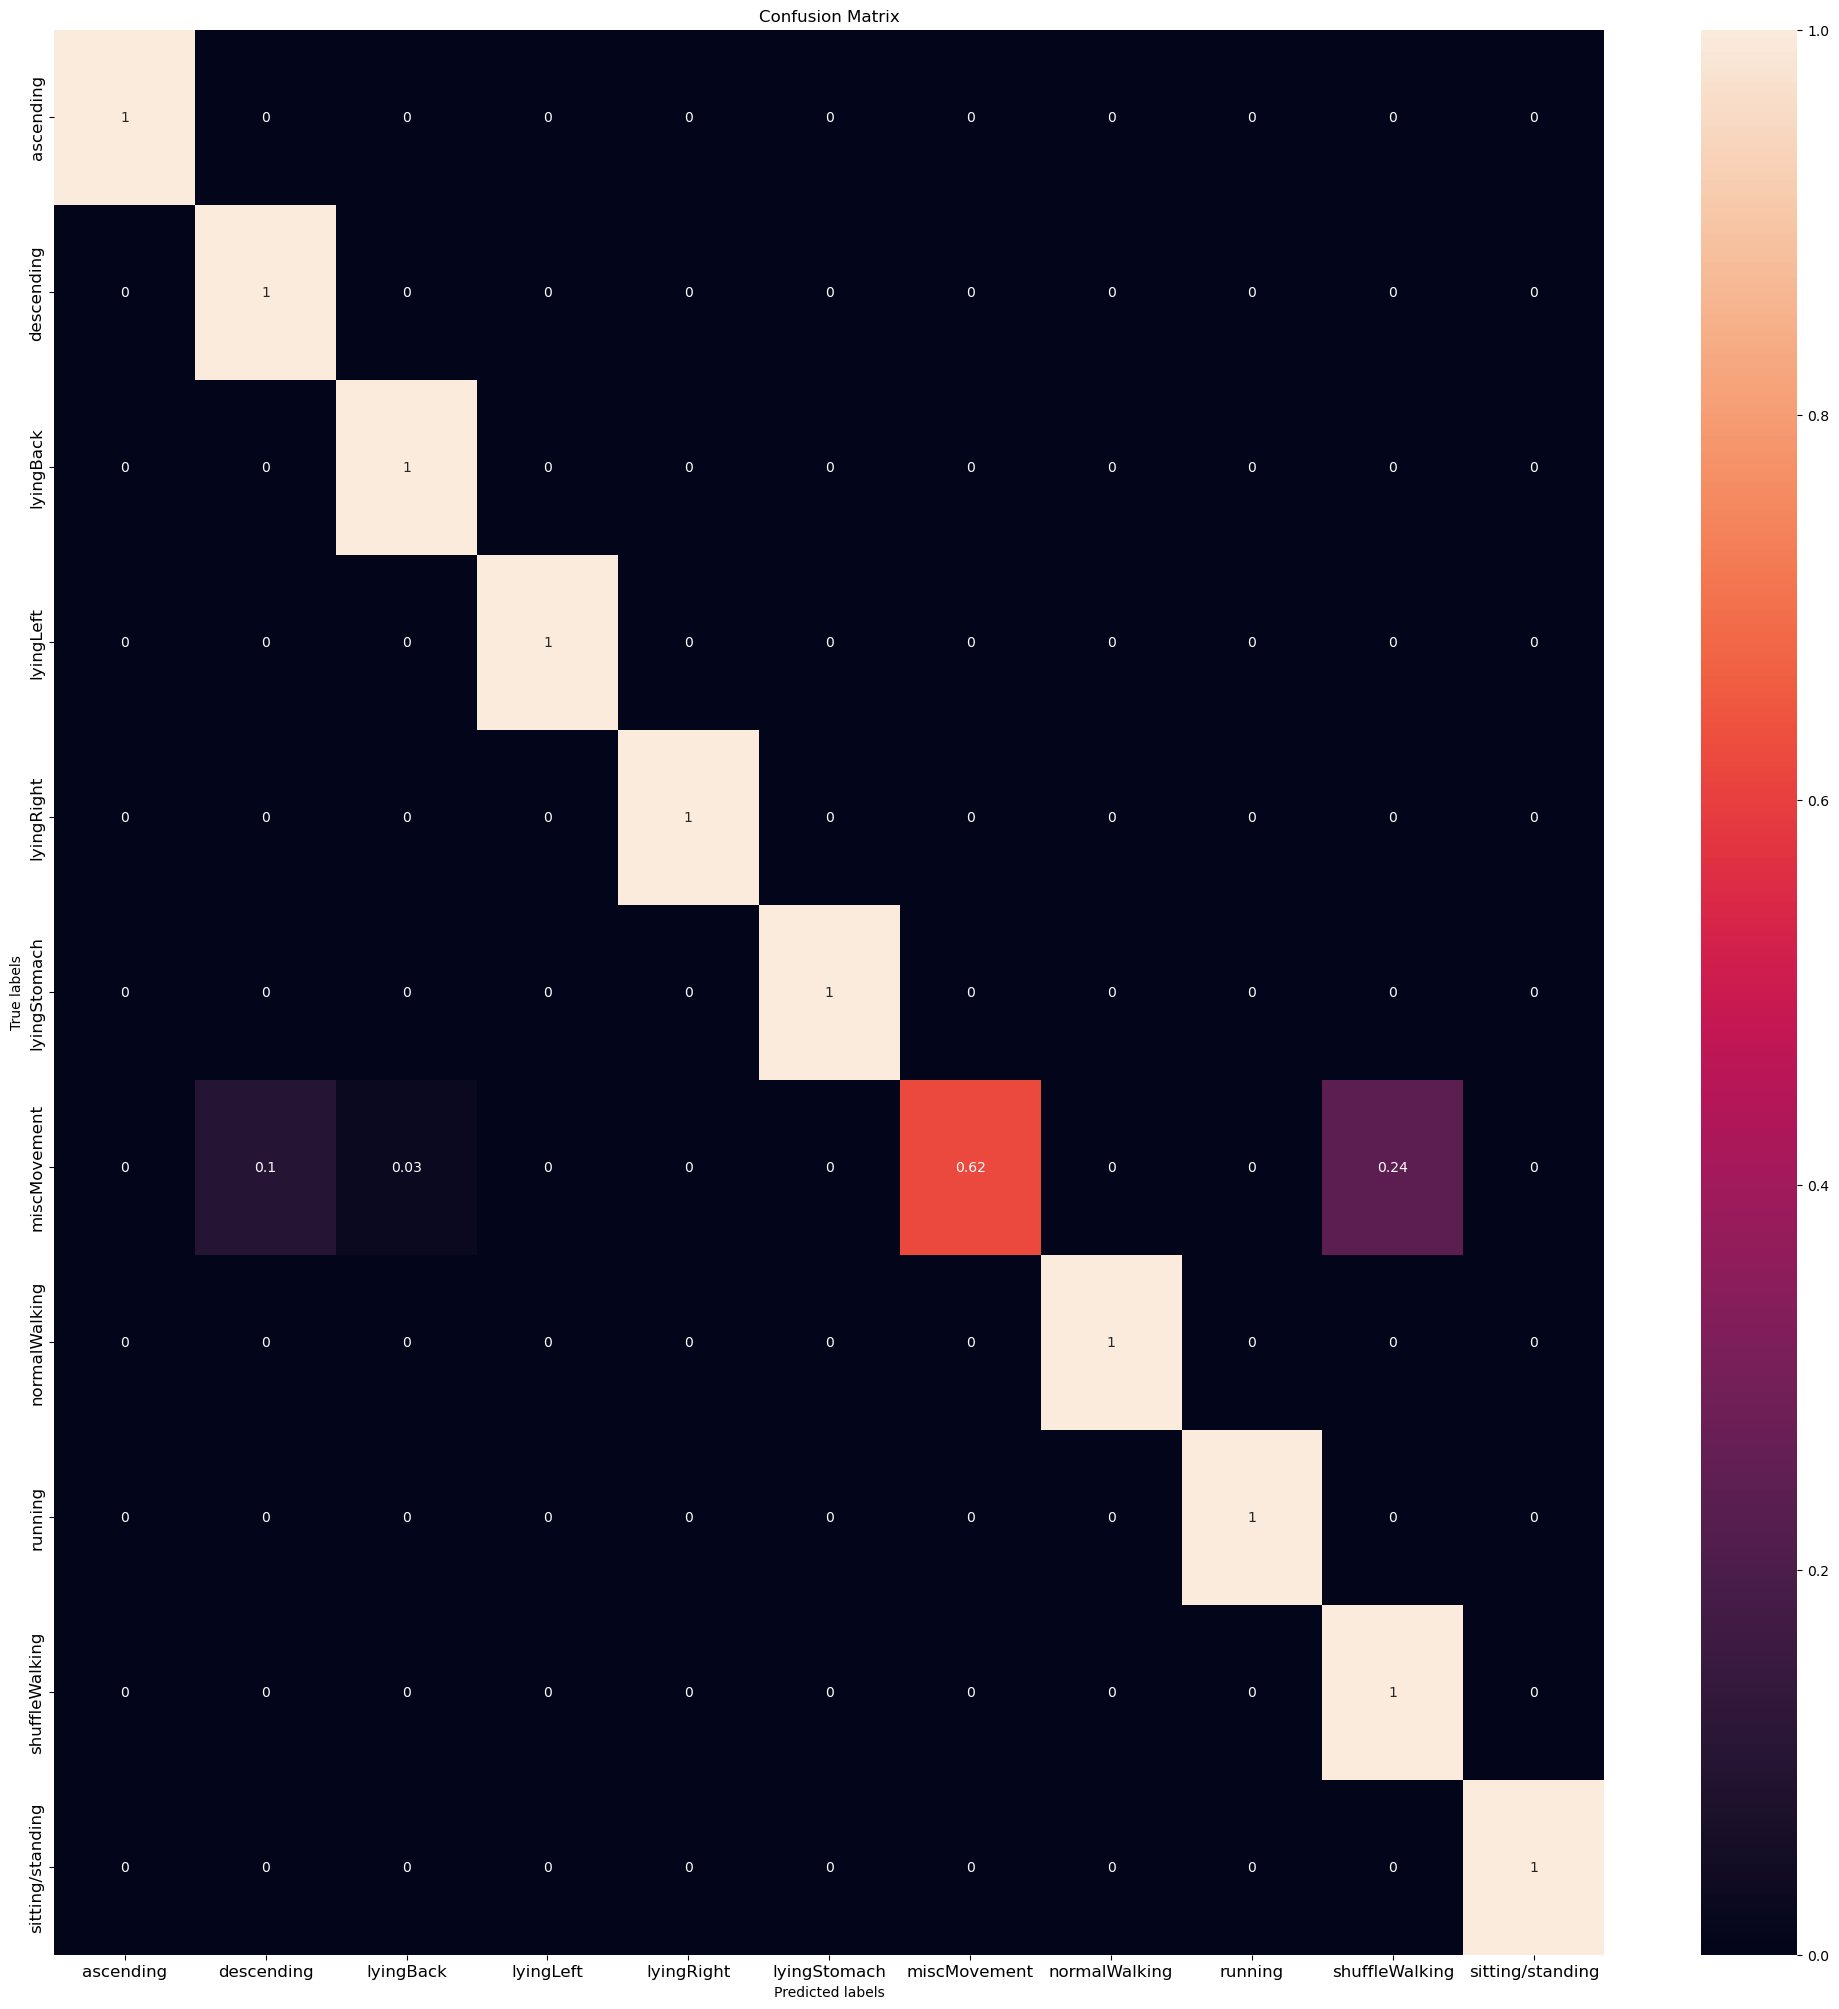

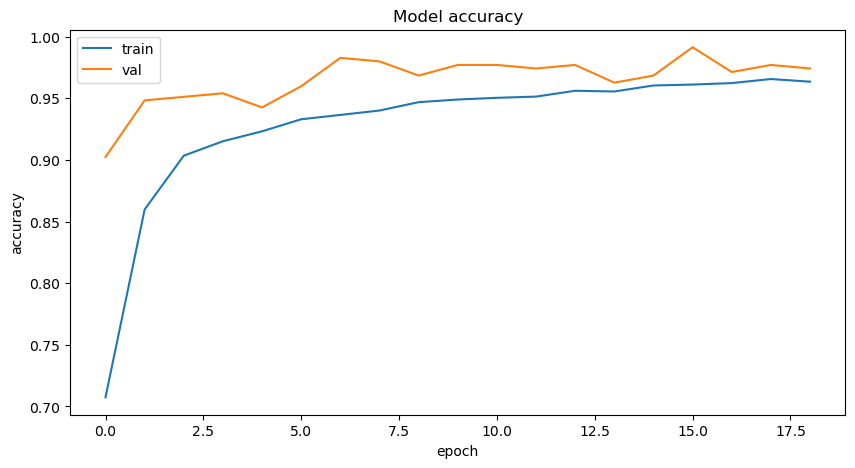

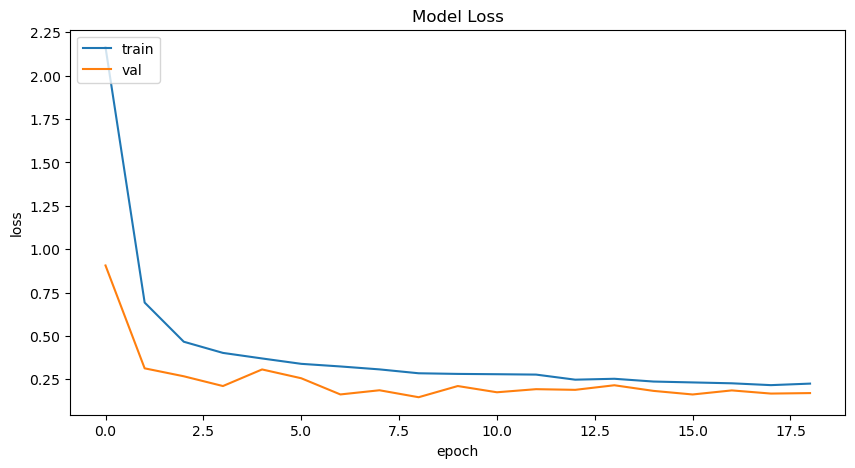

In [31]:
show_report(cnn_model_v1, cnn_model_v1_history)

In [32]:
def CNN_model_v2(X_train, y_train, X_test, y_test):
    window_size = X_train.shape[1]
    n_features = X_train.shape[2]
    n_classes = len(class_labels)
    
    model = Sequential([
        Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(window_size, n_features), padding='same'),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),

        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        
        Flatten(),

        Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
        Dropout(0.5),
        Dense(n_classes, activation='softmax'),
    ])
    
    # Adjusted learning rate and decay
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=5e-4,
        decay_steps=8000,
        decay_rate=0.95)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
    
    print(f"Training on CNN Model v2:")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

    callbacks_list = [early_stopping, reduce_lr]

    history = model.fit(X_train, y_train,
        batch_size=batch_size, epochs=epochs, callbacks=callbacks_list,
        validation_data=(X_test, y_test), shuffle=True
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    print(f'Test accuracy: {test_accuracy *100:.2f}%%')
    
    return model, history

In [33]:
cnn_model_v2, cnn_model_v2_history = CNN_model_v2(X_train, y_train, X_test, y_test)

Training on CNN Model v2:
Epoch 1/50
377/377 [==============================] - 7s 12ms/step - loss: 3.3376 - accuracy: 0.6217 - val_loss: 2.6115 - val_accuracy: 0.5374 - lr: 4.9880e-04
Epoch 2/50
377/377 [==============================] - 4s 11ms/step - loss: 1.5610 - accuracy: 0.7835 - val_loss: 0.8365 - val_accuracy: 0.9310 - lr: 4.9759e-04
Epoch 3/50
377/377 [==============================] - 4s 11ms/step - loss: 0.8740 - accuracy: 0.8683 - val_loss: 0.4671 - val_accuracy: 0.9569 - lr: 4.9639e-04
Epoch 4/50
377/377 [==============================] - 4s 11ms/step - loss: 0.5838 - accuracy: 0.9113 - val_loss: 0.3552 - val_accuracy: 0.9511 - lr: 4.9519e-04
Epoch 5/50
377/377 [==============================] - 4s 11ms/step - loss: 0.4524 - accuracy: 0.9259 - val_loss: 0.3052 - val_accuracy: 0.9511 - lr: 4.9400e-04
Epoch 6/50
377/377 [==============================] - 4s 11ms/step - loss: 0.3842 - accuracy: 0.9372 - val_loss: 0.2878 - val_accuracy: 0.9454 - lr: 4.9280e-04
Epoch 7/50
377

11/11 [==============================] - 0s 4ms/step
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       0.97      0.97      0.97        29
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        29
           5       0.97      1.00      0.98        29
           6       1.00      0.83      0.91        29
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00        29
           9       0.91      1.00      0.95        29
          10       1.00      1.00      1.00        58

    accuracy                           0.98       348
   macro avg       0.98      0.98      0.98       348
weigh

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


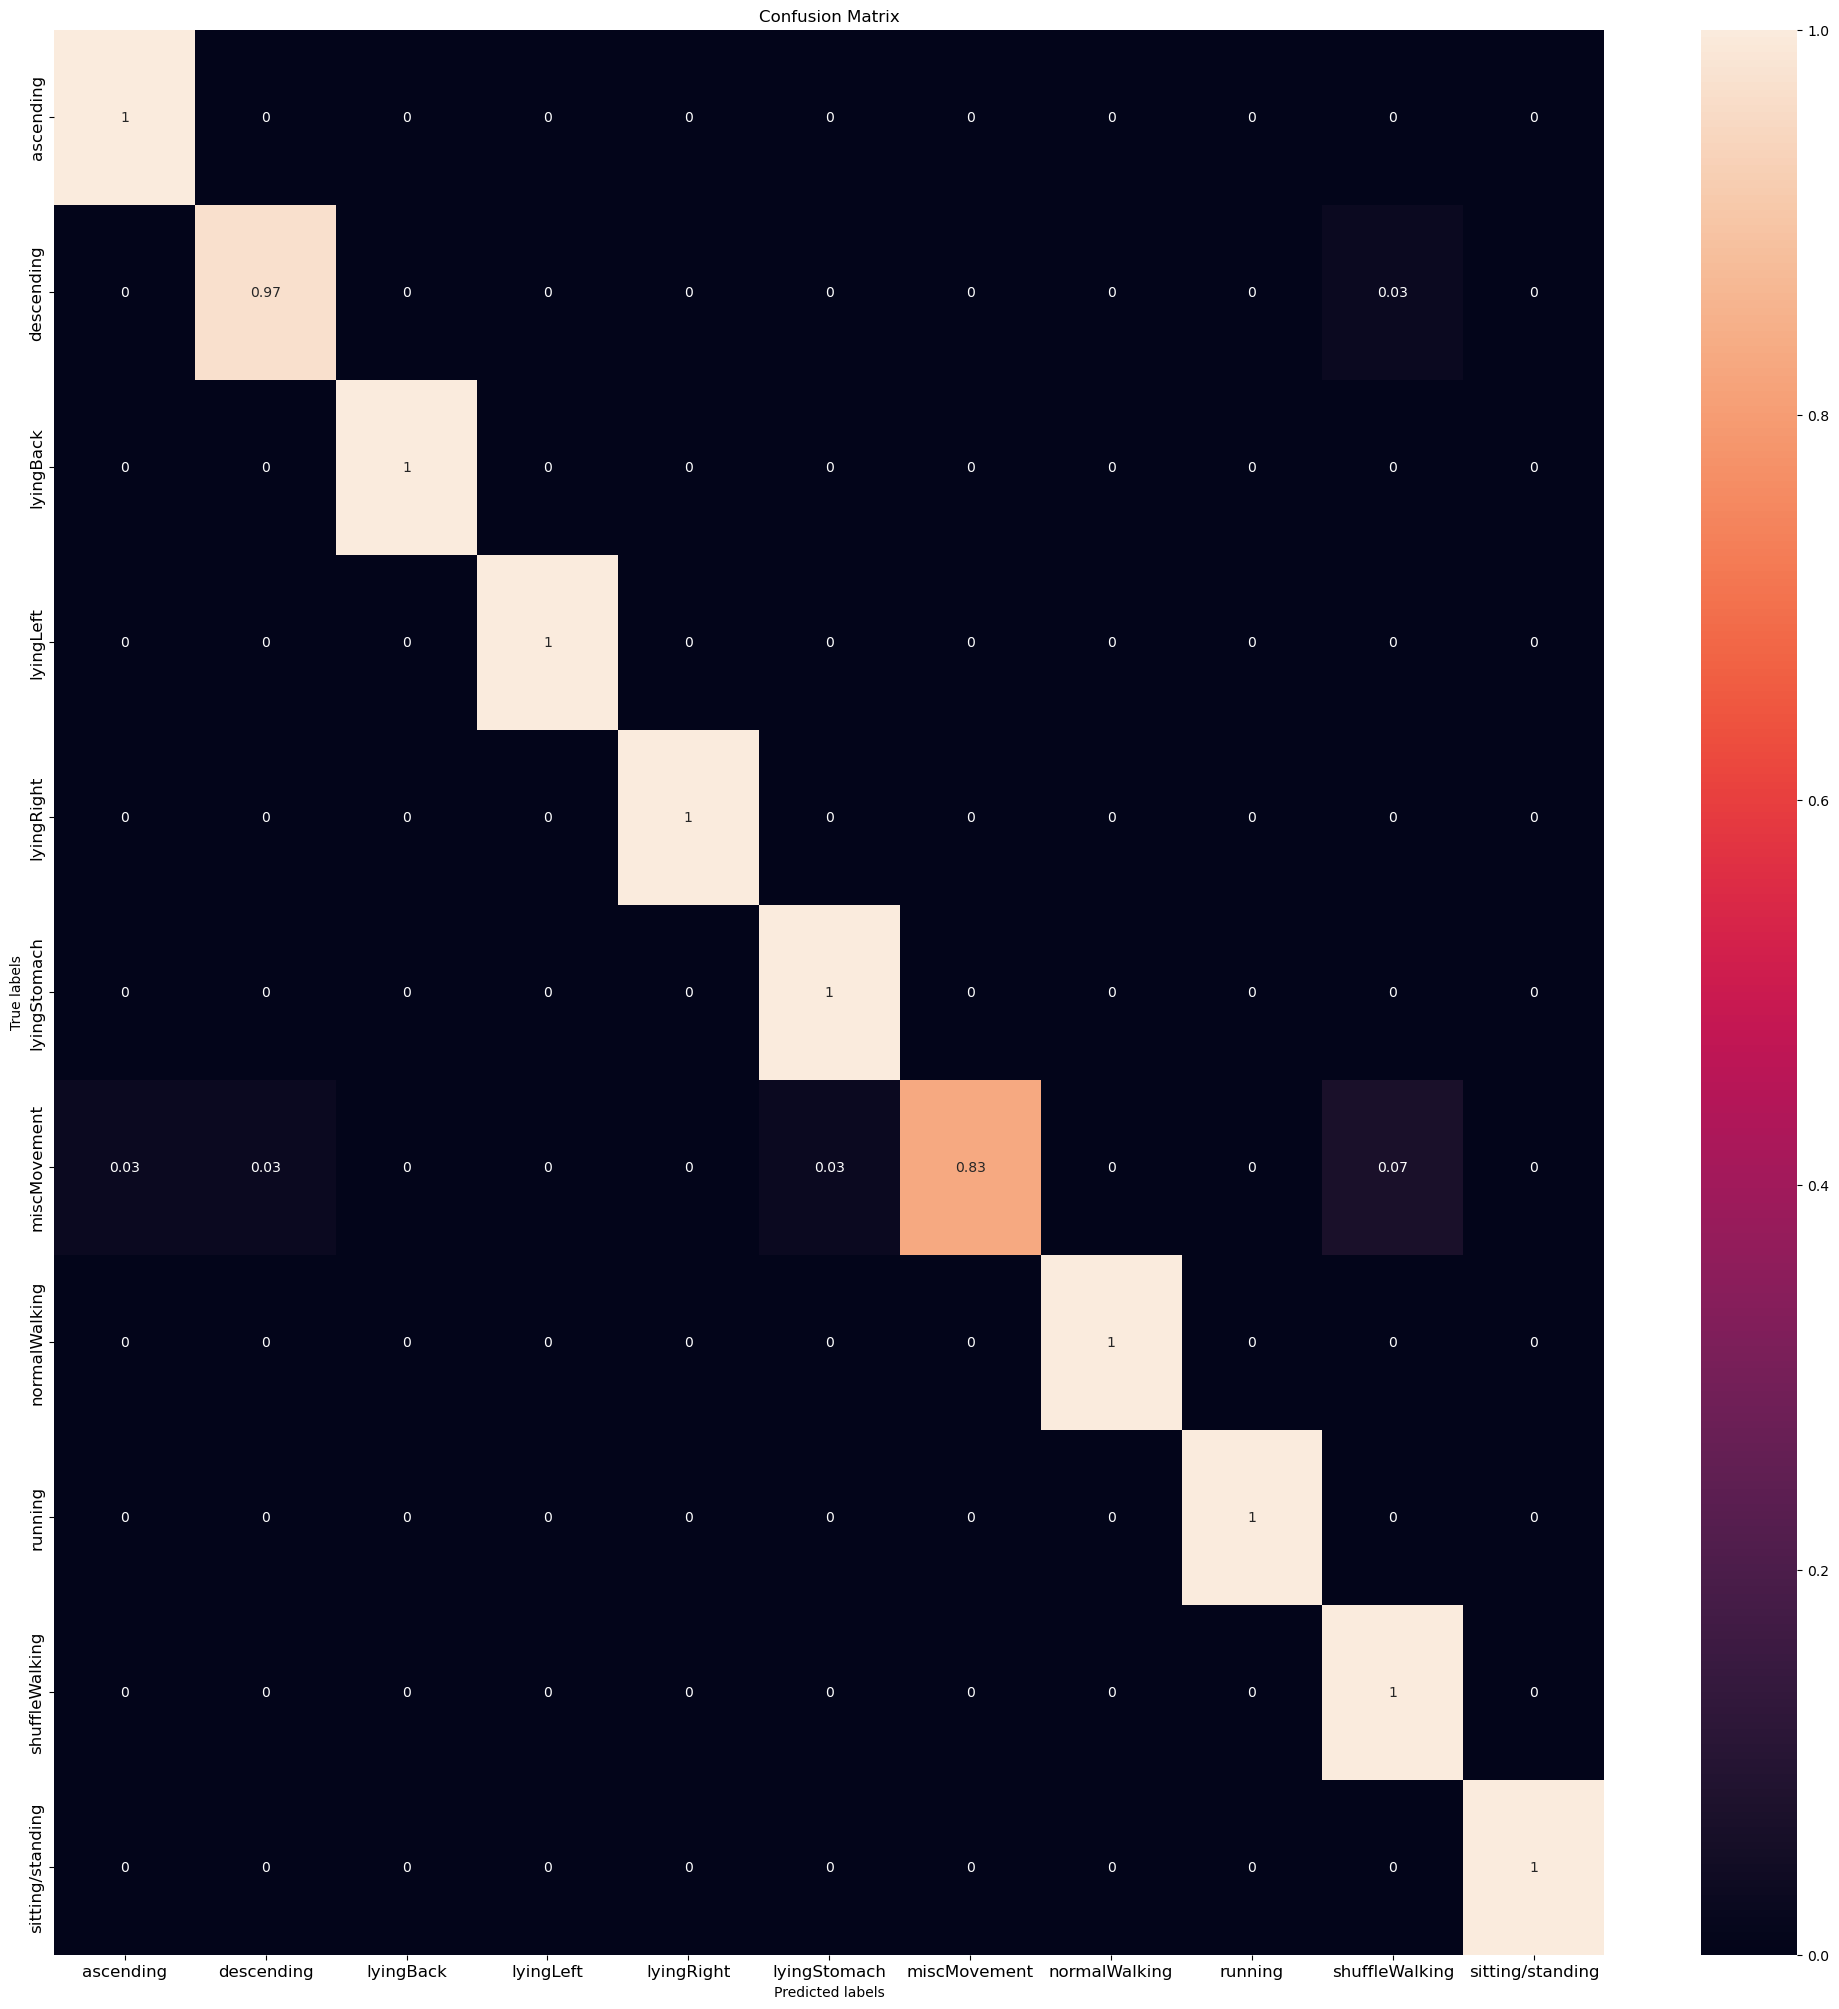

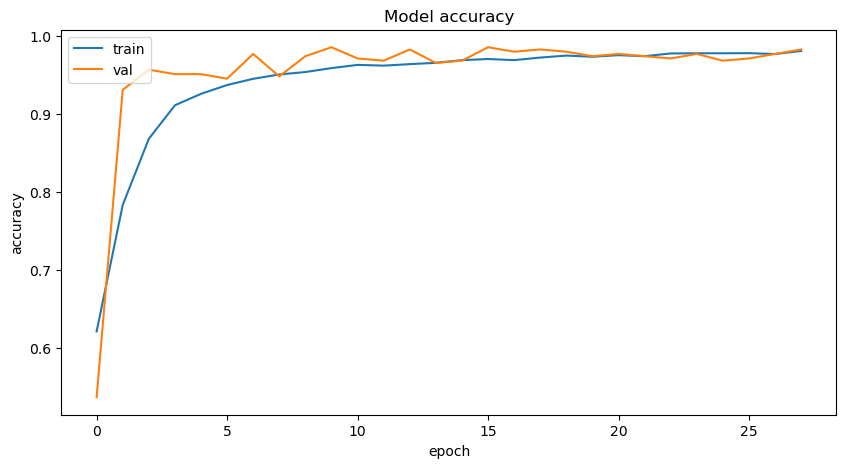

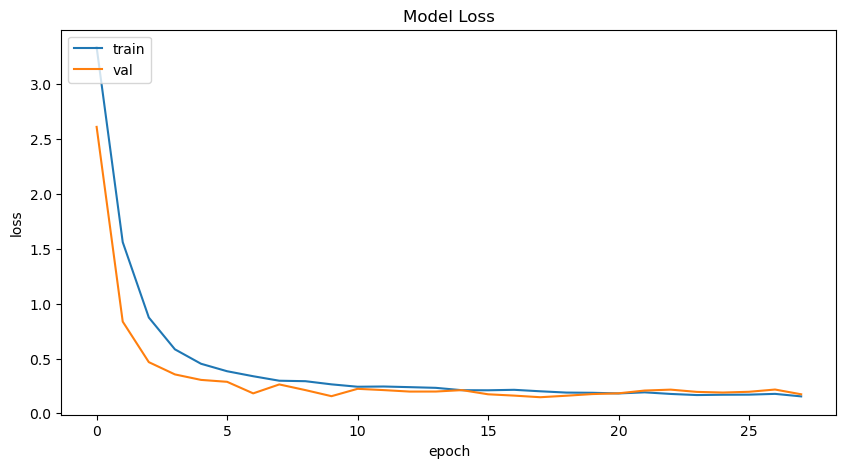

In [34]:
show_report(cnn_model_v2, cnn_model_v2_history)

In [35]:
def CNN_model_v3(X_train, y_train, X_test, y_test):
    window_size = X_train.shape[1]
    n_features = X_train.shape[2]
    n_classes = len(class_labels)
    
    model = Sequential([
        # First block with residual connection
        Conv1D(filters=128, kernel_size=5, padding='same', input_shape=(window_size, n_features)),
        BatchNormalization(),
        ReLU(),
        Conv1D(filters=128, kernel_size=5, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Second block with residual connection
        Conv1D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv1D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        GlobalAveragePooling1D(),

        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(n_classes, activation='softmax')
    ])
    
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
    
    print(f"Training on CNN Model v3:")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

    callbacks_list = [early_stopping, reduce_lr]

    history = model.fit(X_train, y_train,
        batch_size=batch_size, epochs=epochs, callbacks=callbacks_list,
        validation_data=(X_test, y_test), shuffle=True
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    print(f'Test accuracy: {test_accuracy *100:.2f}%%')
    
    return model, history

In [36]:
cnn_model_v3, cnn_model_v3_history = CNN_model_v3(X_train, y_train, X_test, y_test)

Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9754 - accuracy: 0.7884 - val_loss: 0.5688 - val_accuracy: 0.8764 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5350 - accuracy: 0.9031 - val_loss: 0.2952 - val_accuracy: 0.9684 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3994 - accuracy: 0.9284 - val_loss: 0.2071 - val_accuracy: 0.9741 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3222 - accuracy: 0.9359 - val_loss: 0.1790 - val_accuracy: 0.9684 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2793 - accuracy: 0.9434 - val_loss: 0.1462 - val_accuracy: 0.9799 - lr: 9.8035e-04
Epoch 6/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2382 - accuracy: 0.9519 - val_loss: 0.1038 - val_accuracy: 0.9914 - lr: 9.7646e-04
Epoch 7/50
377

161/161 [==============================] - 1s 4ms/step
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       433
           1       0.92      0.91      0.92       432
           2       0.99      1.00      1.00       434
           3       1.00      1.00      1.00       435
           4       0.98      1.00      0.99       435
           5       1.00      1.00      1.00       433
           6       0.92      0.79      0.85       403
           7       0.92      0.91      0.91       435
           8       0.98      0.93      0.96       429
           9       0.76      0.91      0.83       406
          10       1.00      1.00      1.00       867

    accuracy                           0.95      5142
   macro avg       0.95      0.95      0.95      5142
wei

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


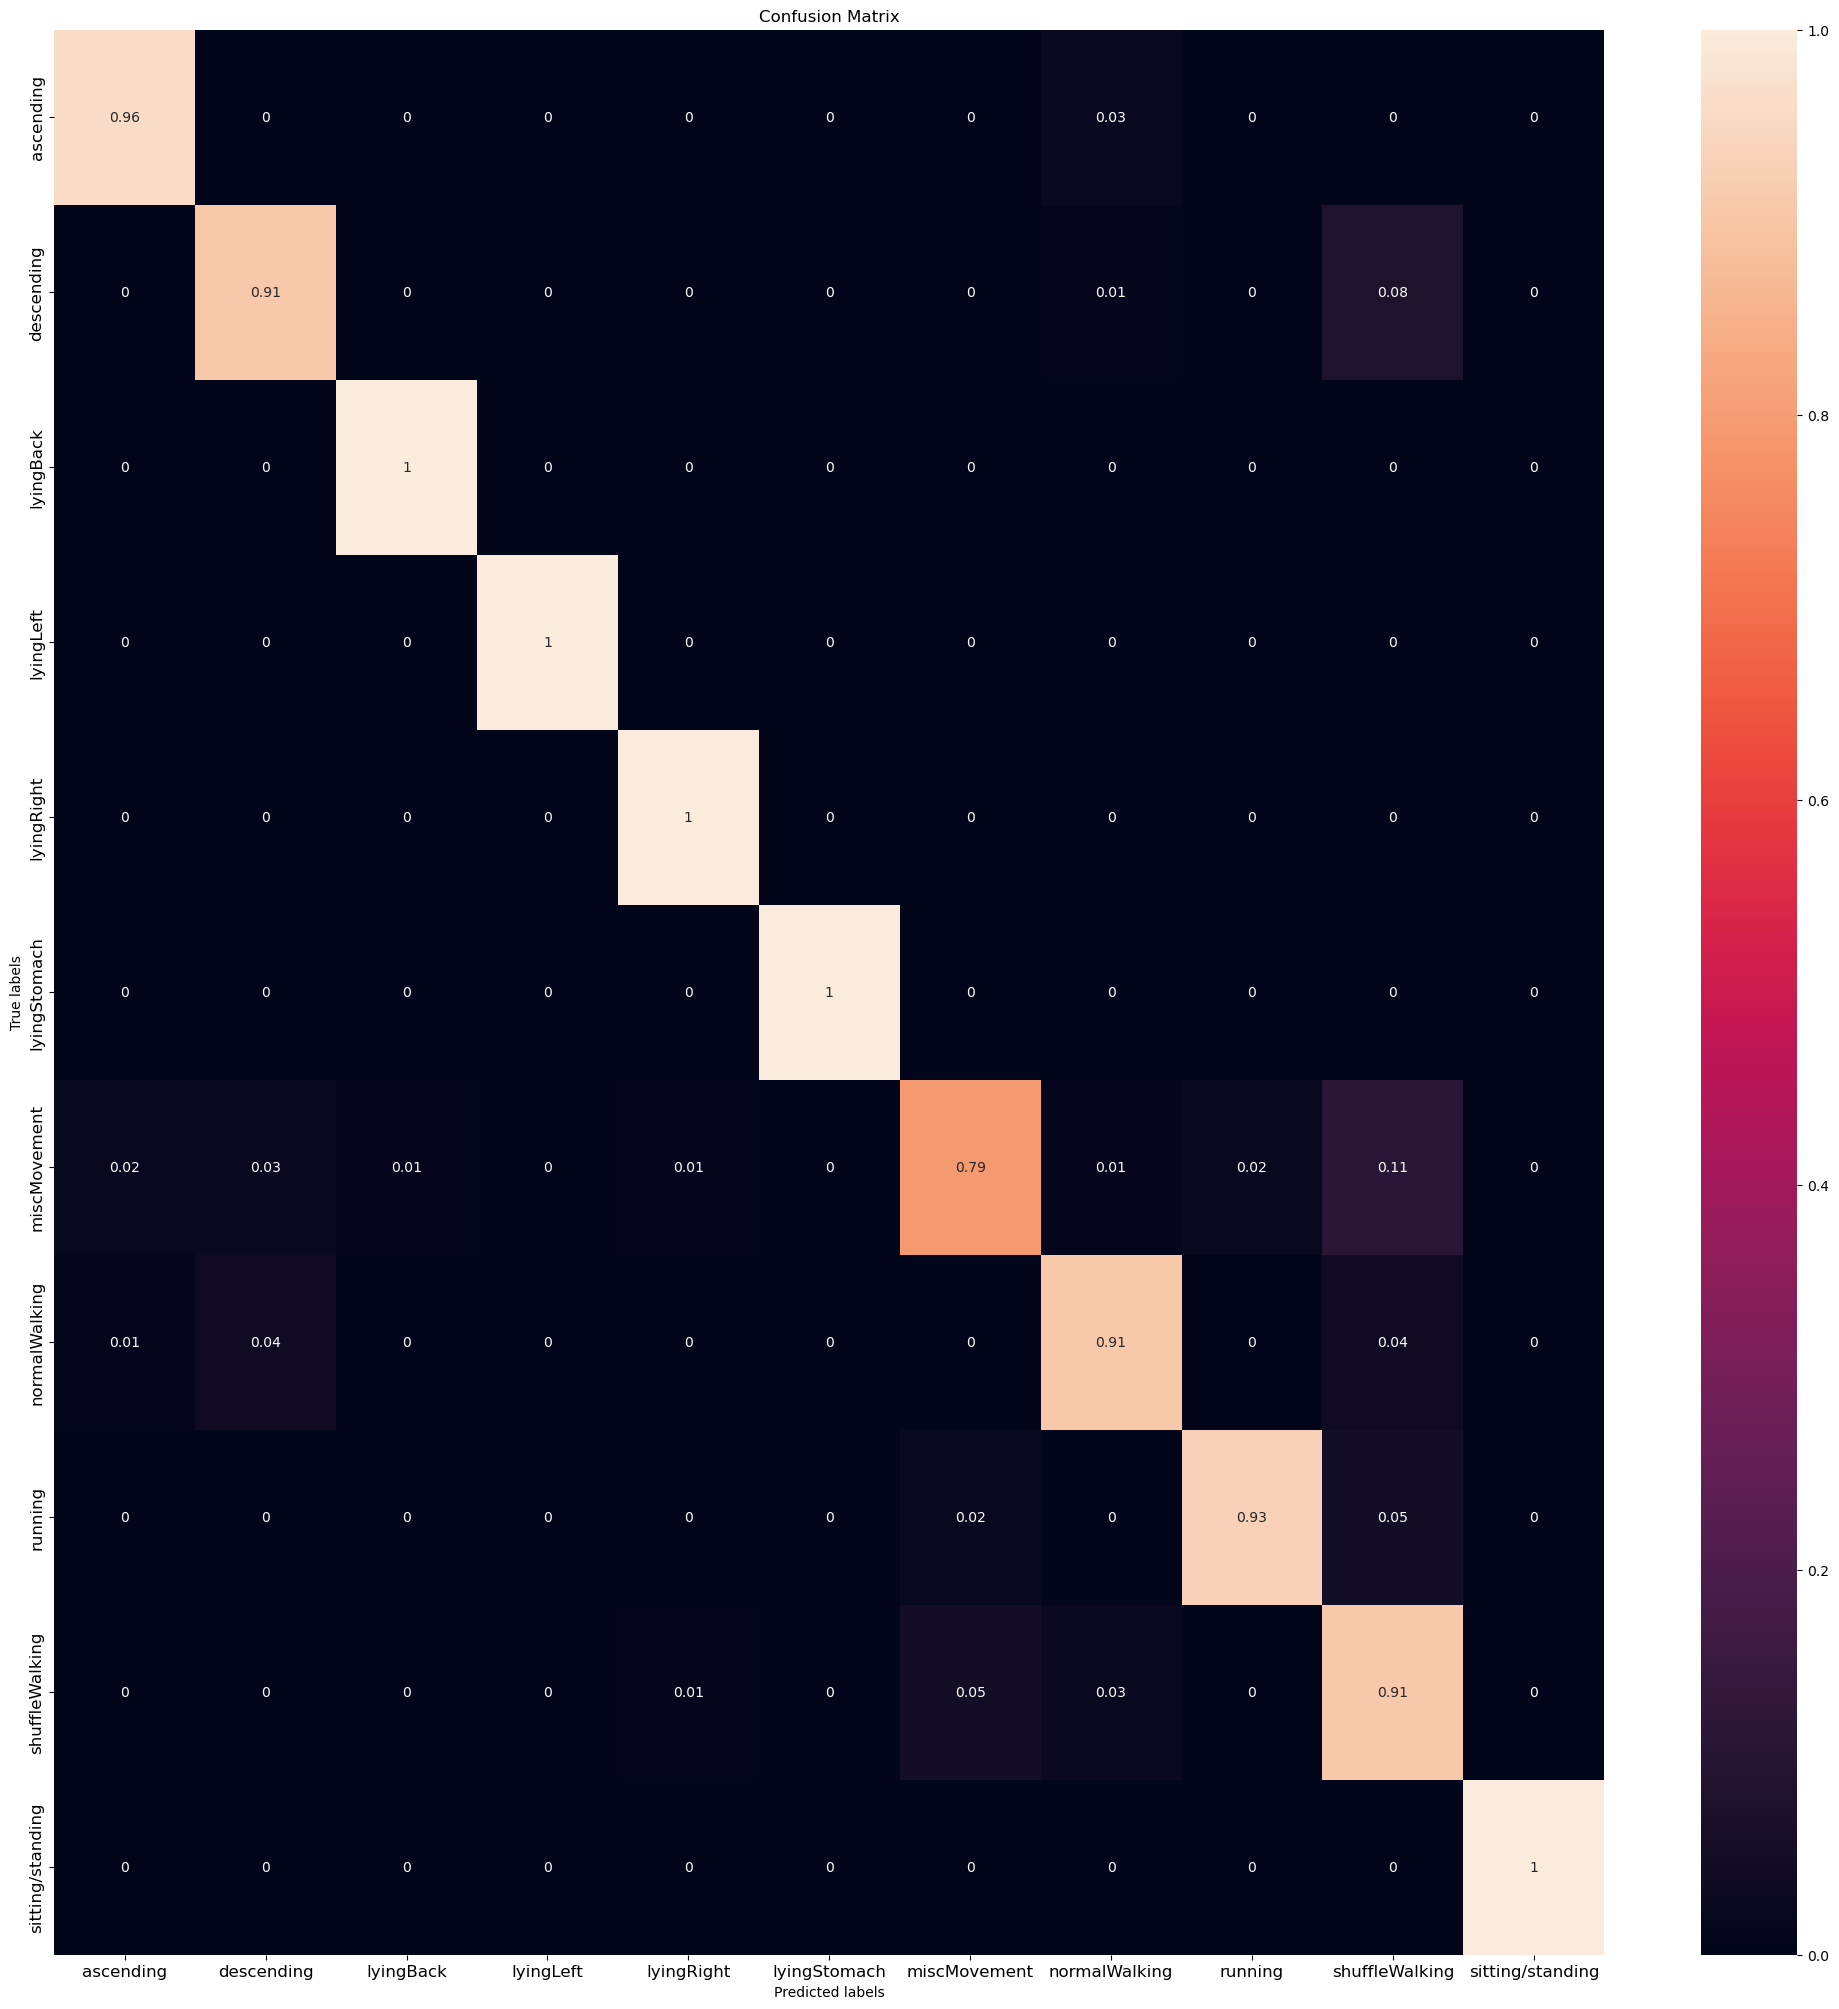

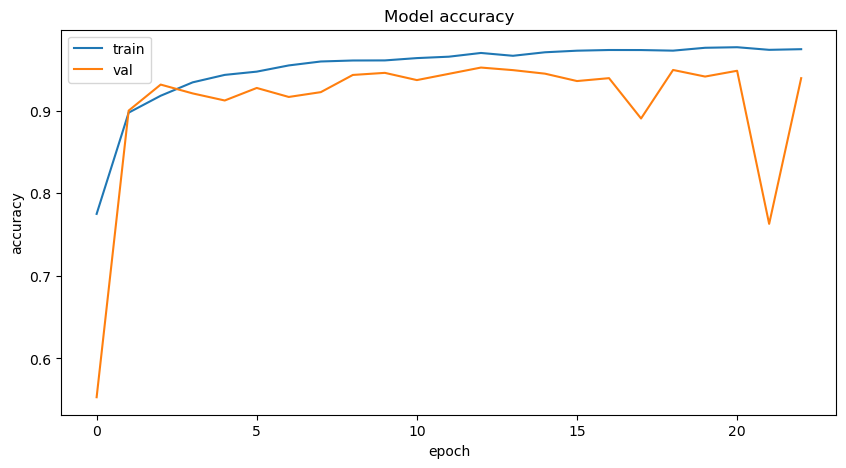

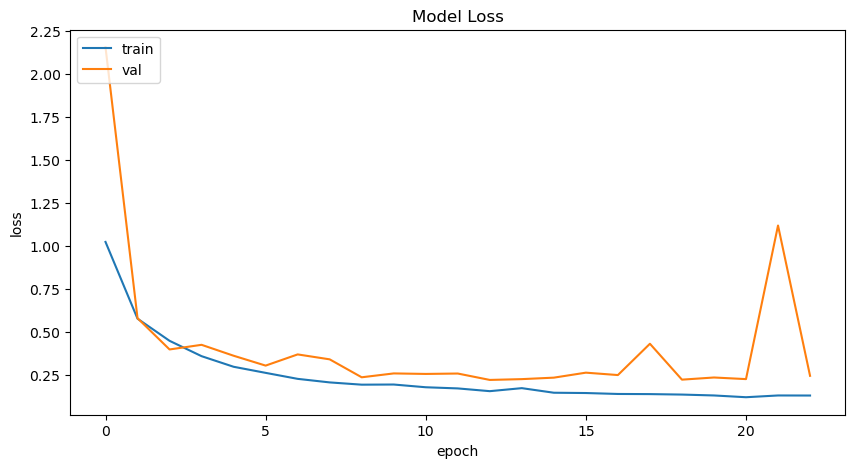

In [31]:
show_report(cnn_model_v3, cnn_model_v3_history)

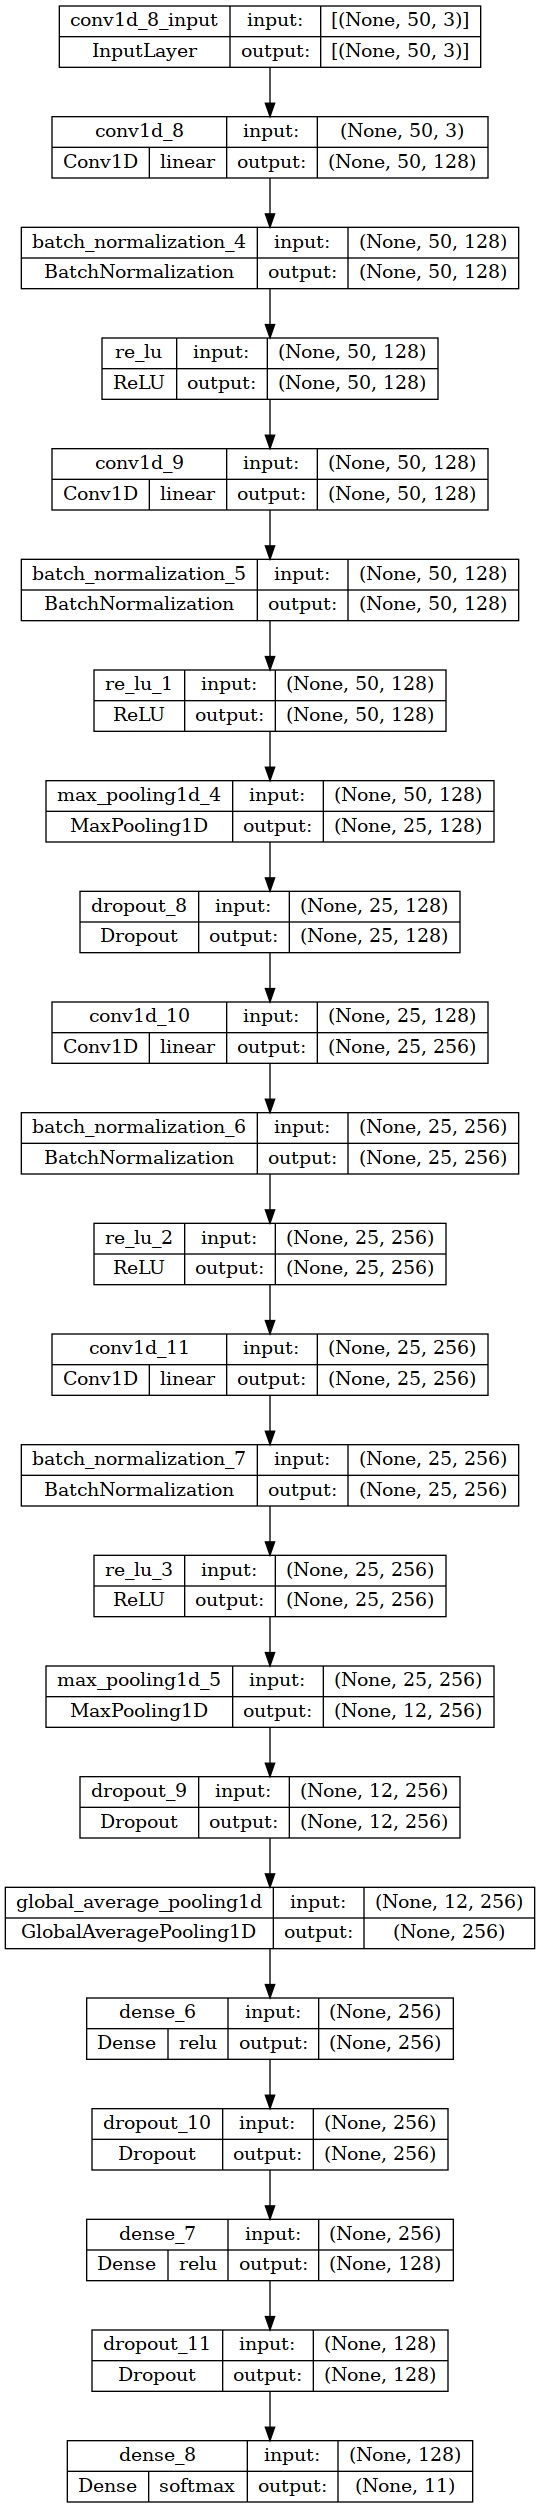

In [37]:
tf.keras.utils.plot_model(cnn_model_v3, show_shapes=True, show_layer_activations=True)

11/11 [==============================] - 0s 4ms/step
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        29
           5       0.97      1.00      0.98        29
           6       1.00      0.97      0.98        29
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00        29
           9       1.00      1.00      1.00        29
          10       1.00      1.00      1.00        58

    accuracy                           1.00       348
   macro avg       1.00      1.00      1.00       348
weigh

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


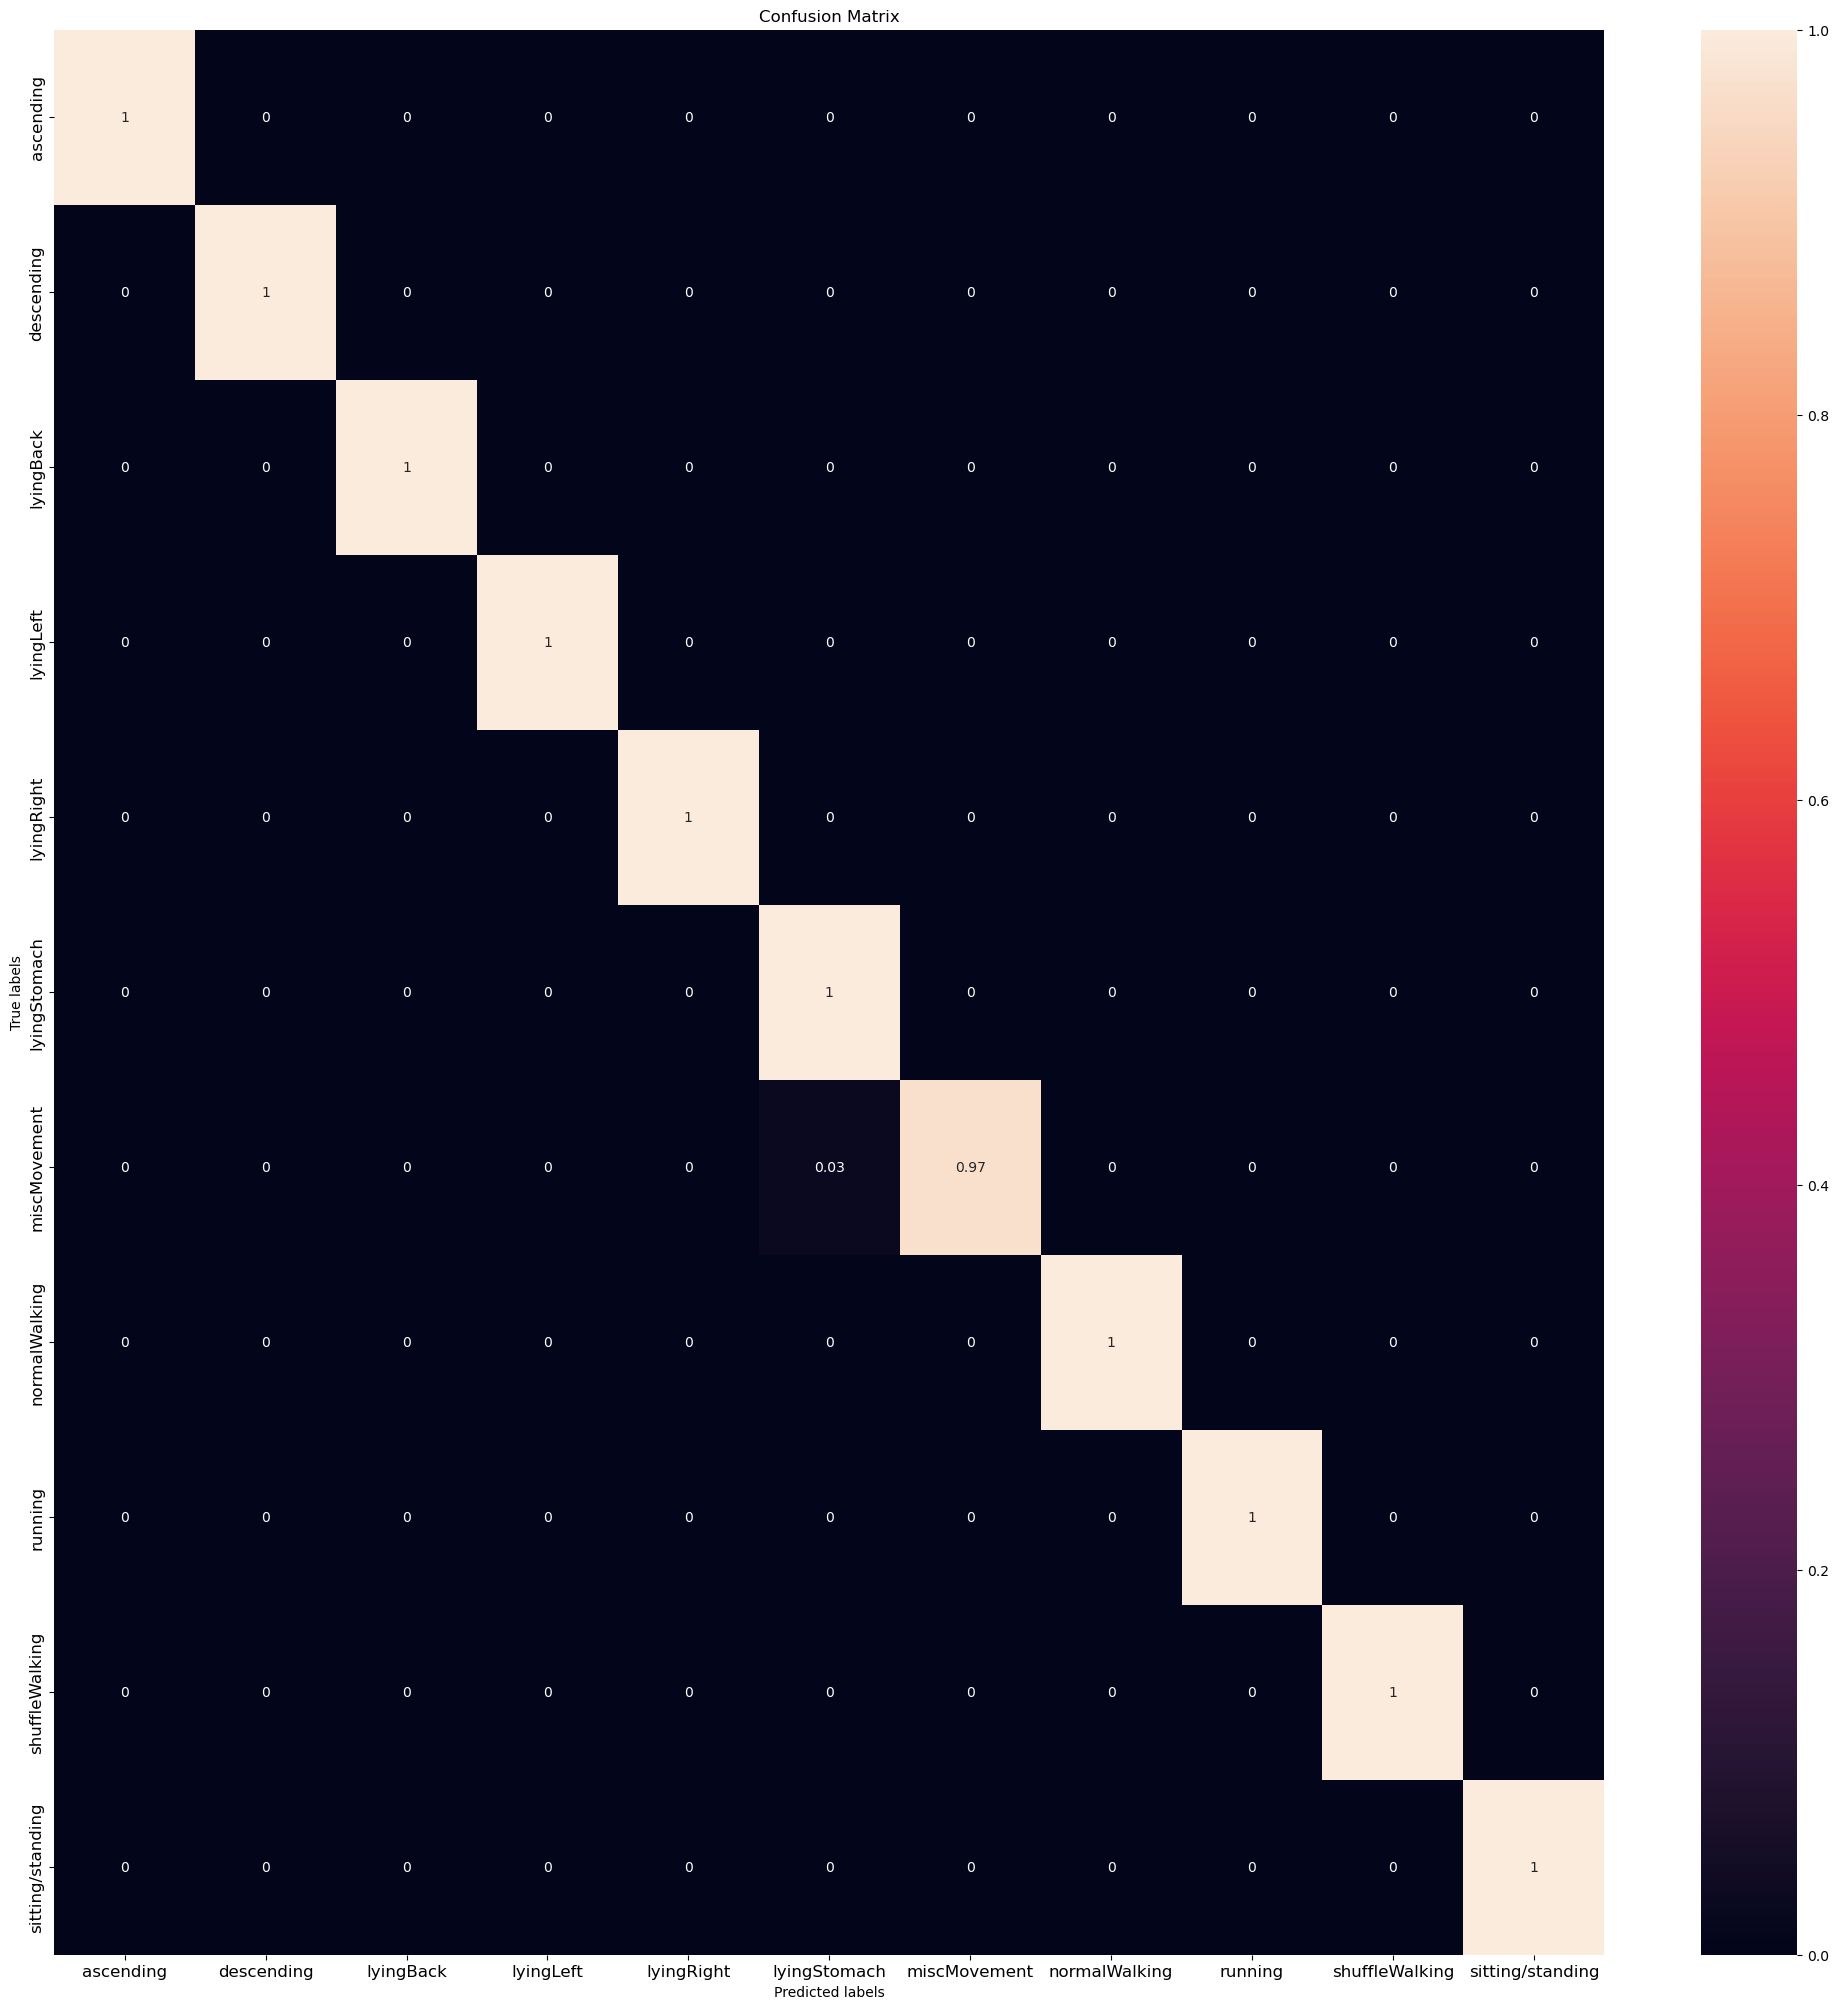

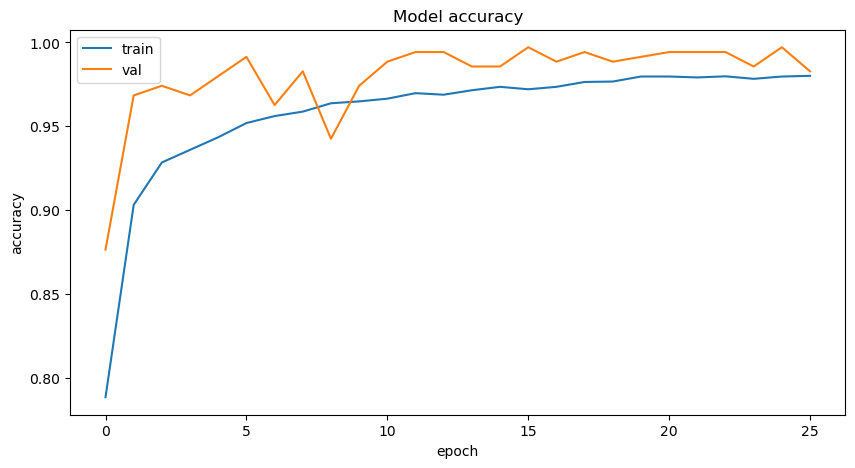

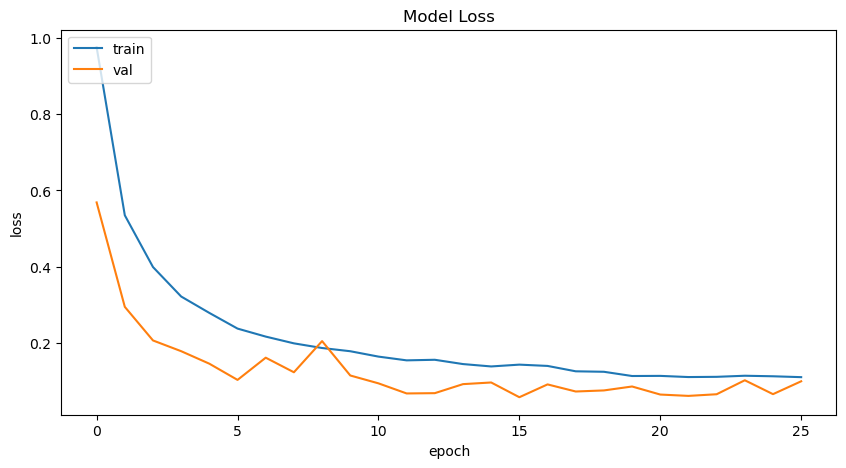

In [38]:
show_report(cnn_model_v3, cnn_model_v3_history)

# Downloading Models

In [43]:
from tensorflow.keras.models import load_model

In [41]:
cnn_model_v1.save('Task1_CNN_Model_v1.h5')

In [45]:
savedModel=load_model('Task1_CNN_Model_v1.h5')
savedModel.evaluate(X_test, y_test)

11/11 [==============================] - 0s 5ms/step - loss: 0.1463 - accuracy: 0.9684


[0.1462772935628891, 0.9683908224105835]

# LOO Accuracy Evaluation

In [39]:
loo_model_histories = {}
logo = LeaveOneGroupOut()

y_predictions = []
y_truth = []

window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap (step_size=25)
n_classes = 11

for train_ix, test_ix in logo.split(X_with_subject_id, y_with_subject_id, groups=X_with_subject_id.subject_id):
    
    X_train_df = X_with_subject_id.loc[train_ix]
    X_test_df = X_with_subject_id.loc[test_ix]

    y_train_df = y_with_subject_id.loc[train_ix]
    y_test_df = y_with_subject_id.loc[test_ix]


    X_train_sliding_windows = group_into_sliding_windows(X_train_df,window_size,step_size)
    X_test_sliding_windows = group_into_sliding_windows(X_test_df,window_size,step_size)

    X_train_generated, y_train_generated = generate_data_from_sliding_windows(X_train_sliding_windows)
    X_test_generated, y_test_generated = generate_data_from_sliding_windows(X_test_sliding_windows)
    
    X_train, y_train, X_test, y_test = convert_values_to_numpy_array(X_train_generated, y_train_generated, X_test_generated, y_test_generated)


    if y_test.shape[1] < n_classes:
            print(f"Skipping this subject:{X_test_df.subject_id.unique()}")
            continue
    else:
            print(f"Testing on subject id:{X_test_df.subject_id.unique()}")

    # model, history = CNN_model_v1(X_train, y_train, X_test, y_test)
    # model, history = CNN_model_v2(X_train, y_train, X_test, y_test)
    model, history = CNN_model_v3(X_train, y_train, X_test, y_test)

    print("LOO Test Accuracy : " , history.history['val_accuracy'][-1])
    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    print(y_pred_labels)
    
    print("*" * 80)
    print("Classification report")
    print("*" * 80)
    print(classification_report(y_true_labels, y_pred_labels))
    print(class_labels)
    
    loo_model_histories[X_test_df.subject_id.unique()[0]] = history
    
    y_predictions.extend(y_pred_labels)
    y_truth.extend(y_true_labels)

X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s1']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9216 - accuracy: 0.7987 - val_loss: 0.4596 - val_accuracy: 0.9368 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5177 - accuracy: 0.9054 - val_loss: 0.2783 - val_accuracy: 0.9598 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3955 - accuracy: 0.9237 - val_loss: 0.2134 - val_accuracy: 0.9713 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3202 - accuracy: 0.9376 - val_loss: 0.1792 - val_accuracy: 0.9741 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2678 - accuracy: 0.9459 - val_loss: 0.1239 - val_accuracy: 0.9856 - lr: 9.8035e-04
Epoch 6/50
377/377 [=============

377/377 [==============================] - 5s 13ms/step - loss: 0.1148 - accuracy: 0.9782 - val_loss: 0.0574 - val_accuracy: 0.9884 - lr: 9.1998e-04
Epoch 22/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1015 - accuracy: 0.9812 - val_loss: 0.0414 - val_accuracy: 0.9971 - lr: 9.1633e-04
Epoch 23/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1230 - accuracy: 0.9770 - val_loss: 0.0425 - val_accuracy: 1.0000 - lr: 9.1270e-04
Epoch 24/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1058 - accuracy: 0.9807 - val_loss: 0.2347 - val_accuracy: 0.9335 - lr: 9.0908e-04
Epoch 25/50
375/377 [============================>.] - ETA: 0s - loss: 0.1085 - accuracy: 0.9805
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00018109569791704418.
377/377 [==============================] - 5s 13ms/step - loss: 0.1084 - accuracy: 0.9805 - val_loss: 0.0966 - val_accuracy: 0.9740 - lr: 9.0548e-04
Epoch 26/50
377/377 [=======================

Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3887 - accuracy: 0.9275 - val_loss: 0.5389 - val_accuracy: 0.8754 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3107 - accuracy: 0.9399 - val_loss: 0.2977 - val_accuracy: 0.8957 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2707 - accuracy: 0.9456 - val_loss: 0.7482 - val_accuracy: 0.8348 - lr: 9.8035e-04
Epoch 6/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2354 - accuracy: 0.9517 - val_loss: 0.2973 - val_accuracy: 0.9362 - lr: 9.7646e-04
Epoch 7/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2089 - accuracy: 0.9579 - val_loss: 0.5999 - val_accuracy: 0.8464 - lr: 9.7259e-04
Epoch 8/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1988 - accuracy: 0.9586 - val_loss: 0.5974 - val_accuracy: 0.8928 - lr: 9.6873e-04
Epoch 9/50
377/377 [====================

377/377 [==============================] - 5s 13ms/step - loss: 0.1543 - accuracy: 0.9706 - val_loss: 0.1402 - val_accuracy: 0.9770 - lr: 9.4968e-04
Epoch 14/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1482 - accuracy: 0.9708 - val_loss: 0.1258 - val_accuracy: 0.9828 - lr: 9.4592e-04
Epoch 15/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1372 - accuracy: 0.9742 - val_loss: 0.1751 - val_accuracy: 0.9713 - lr: 9.4217e-04
Epoch 16/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1452 - accuracy: 0.9731 - val_loss: 0.0969 - val_accuracy: 0.9914 - lr: 9.3843e-04
Epoch 17/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1316 - accuracy: 0.9757 - val_loss: 0.1579 - val_accuracy: 0.9770 - lr: 9.3471e-04
Epoch 18/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1206 - accuracy: 0.9772 - val_loss: 0.5059 - val_accuracy: 0.7989 - lr: 9.3101e-04
Epoch 19/50
377/377 [=========================

Epoch 21/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1172 - accuracy: 0.9784 - val_loss: 0.1614 - val_accuracy: 0.9623 - lr: 9.1998e-04
Epoch 22/50
376/377 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9805Restoring model weights from the end of the best epoch: 12.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00018326658755540848.
377/377 [==============================] - 5s 13ms/step - loss: 0.1097 - accuracy: 0.9804 - val_loss: 0.5164 - val_accuracy: 0.9159 - lr: 9.1633e-04
Epoch 22: early stopping
11/11 [==============================] - 0s 6ms/step - loss: 0.0956 - accuracy: 0.9797
Test accuracy: 97.97%%
LOO Test Accuracy :  0.9159420132637024
11/11 [==============================] - 0s 4ms/step
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  

377/377 [==============================] - 5s 13ms/step - loss: 0.1290 - accuracy: 0.9756 - val_loss: 0.8733 - val_accuracy: 0.8161 - lr: 9.3101e-04
Epoch 19/50
374/377 [============================>.] - ETA: 0s - loss: 0.1277 - accuracy: 0.9760
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00018546351930126548.
377/377 [==============================] - 5s 13ms/step - loss: 0.1275 - accuracy: 0.9761 - val_loss: 0.8362 - val_accuracy: 0.8448 - lr: 9.2732e-04
Epoch 20/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1209 - accuracy: 0.9789 - val_loss: 0.4474 - val_accuracy: 0.8879 - lr: 9.2364e-04
Epoch 21/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1186 - accuracy: 0.9772 - val_loss: 1.2092 - val_accuracy: 0.8305 - lr: 9.1998e-04
Epoch 22/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1160 - accuracy: 0.9797 - val_loss: 0.4634 - val_accuracy: 0.9138 - lr: 9.1633e-04
Epoch 23/50
377/377 [=======================

377/377 [==============================] - 5s 13ms/step - loss: 0.1053 - accuracy: 0.9803 - val_loss: 0.1010 - val_accuracy: 0.9713 - lr: 9.0548e-04
Epoch 26/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1014 - accuracy: 0.9816 - val_loss: 0.0797 - val_accuracy: 0.9856 - lr: 9.0189e-04
Epoch 27/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0990 - accuracy: 0.9824 - val_loss: 0.0743 - val_accuracy: 0.9856 - lr: 8.9831e-04
Epoch 28/50
376/377 [============================>.] - ETA: 0s - loss: 0.1066 - accuracy: 0.9808Restoring model weights from the end of the best epoch: 18.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.00017895052442327142.
377/377 [==============================] - 5s 13ms/step - loss: 0.1066 - accuracy: 0.9808 - val_loss: 0.0951 - val_accuracy: 0.9799 - lr: 8.9475e-04
Epoch 28: early stopping
11/11 [==============================] - 0s 6ms/step - loss: 0.0583 - accuracy: 0.9971
Test accuracy: 99.71%%
LOO Test A

11/11 [==============================] - 0s 3ms/step
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  6  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 1

Epoch 18/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1308 - accuracy: 0.9754 - val_loss: 0.0448 - val_accuracy: 1.0000 - lr: 9.3101e-04
Epoch 19/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1331 - accuracy: 0.9743 - val_loss: 0.0384 - val_accuracy: 1.0000 - lr: 9.2732e-04
Epoch 20/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1237 - accuracy: 0.9770 - val_loss: 0.0379 - val_accuracy: 1.0000 - lr: 9.2364e-04
Epoch 21/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1185 - accuracy: 0.9778 - val_loss: 0.0377 - val_accuracy: 1.0000 - lr: 9.1998e-04
Epoch 22/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1182 - accuracy: 0.9780 - val_loss: 0.0409 - val_accuracy: 1.0000 - lr: 9.1633e-04
Epoch 23/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1184 - accuracy: 0.9780 - val_loss: 0.0364 - val_accuracy: 1.0000 - lr: 9.1270e-04
Epoch 24/50
377/377 [=============

Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5154 - accuracy: 0.9101 - val_loss: 0.7397 - val_accuracy: 0.7874 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3940 - accuracy: 0.9270 - val_loss: 0.8578 - val_accuracy: 0.7615 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3188 - accuracy: 0.9388 - val_loss: 1.2149 - val_accuracy: 0.7529 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2743 - accuracy: 0.9453 - val_loss: 0.4614 - val_accuracy: 0.8276 - lr: 9.8035e-04
Epoch 6/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2483 - accuracy: 0.9496 - val_loss: 0.6977 - val_accuracy: 0.8592 - lr: 9.7646e-04
Epoch 7/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2141 - accuracy: 0.9566 - val_loss: 0.8783 - val_accuracy: 0.8678 - lr: 9.7259e-04
Epoch 8/50
377/377 [====================

377/377 [==============================] - 5s 13ms/step - loss: 0.1855 - accuracy: 0.9608 - val_loss: 1.0322 - val_accuracy: 0.8617 - lr: 9.6489e-04
Epoch 10/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1646 - accuracy: 0.9679 - val_loss: 0.7736 - val_accuracy: 0.8559 - lr: 9.6107e-04
Epoch 11/50
377/377 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9669
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00019145157421007752.
377/377 [==============================] - 5s 13ms/step - loss: 0.1616 - accuracy: 0.9669 - val_loss: 1.2352 - val_accuracy: 0.8530 - lr: 9.5726e-04
Epoch 12/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1643 - accuracy: 0.9666 - val_loss: 0.9936 - val_accuracy: 0.8847 - lr: 9.5346e-04
Epoch 13/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1447 - accuracy: 0.9709 - val_loss: 0.7417 - val_accuracy: 0.8732 - lr: 9.4968e-04
Epoch 14/50
377/377 [=======================

Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2589 - accuracy: 0.9474 - val_loss: 1.5796 - val_accuracy: 0.6830 - lr: 9.8035e-04
Epoch 6/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2385 - accuracy: 0.9501 - val_loss: 0.7253 - val_accuracy: 0.7839 - lr: 9.7646e-04
Epoch 7/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2355 - accuracy: 0.9505 - val_loss: 0.6993 - val_accuracy: 0.8040 - lr: 9.7259e-04
Epoch 8/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2000 - accuracy: 0.9573 - val_loss: 0.5628 - val_accuracy: 0.8473 - lr: 9.6873e-04
Epoch 9/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1814 - accuracy: 0.9631 - val_loss: 1.5900 - val_accuracy: 0.6974 - lr: 9.6489e-04
Epoch 10/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1694 - accuracy: 0.9656 - val_loss: 1.1220 - val_accuracy: 0.8040 - lr: 9.6107e-04
Epoch 11/50
377/377 [==================

X_train shape = (24089, 50, 3)
y_train shape = (24089, 11)
X_test shape = (343, 50, 3)
y_test shape = (343, 11)
Testing on subject id:['s39']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9375 - accuracy: 0.8006 - val_loss: 0.5974 - val_accuracy: 0.9271 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5094 - accuracy: 0.9104 - val_loss: 0.5779 - val_accuracy: 0.9038 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3840 - accuracy: 0.9301 - val_loss: 0.2509 - val_accuracy: 0.9854 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3080 - accuracy: 0.9405 - val_loss: 0.4587 - val_accuracy: 0.8630 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2689 - accuracy: 0.9476 - val_loss: 0.3080 - val_accuracy: 0.9096 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

377/377 [==============================] - 5s 13ms/step - loss: 0.5229 - accuracy: 0.9065 - val_loss: 0.3403 - val_accuracy: 0.9282 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3873 - accuracy: 0.9290 - val_loss: 0.2123 - val_accuracy: 0.9828 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3099 - accuracy: 0.9398 - val_loss: 0.2480 - val_accuracy: 0.9483 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2522 - accuracy: 0.9521 - val_loss: 0.2599 - val_accuracy: 0.9425 - lr: 9.8035e-04
Epoch 6/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2383 - accuracy: 0.9522 - val_loss: 0.1890 - val_accuracy: 0.9713 - lr: 9.7646e-04
Epoch 7/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2083 - accuracy: 0.9586 - val_loss: 0.3039 - val_accuracy: 0.9282 - lr: 9.7259e-04
Epoch 8/50
377/377 [==============================]

377/377 [==============================] - 5s 13ms/step - loss: 0.1399 - accuracy: 0.9723 - val_loss: 0.1843 - val_accuracy: 0.9510 - lr: 9.3471e-04
Epoch 18/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1216 - accuracy: 0.9774 - val_loss: 0.1281 - val_accuracy: 0.9683 - lr: 9.3101e-04
Epoch 19/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1223 - accuracy: 0.9767 - val_loss: 0.2057 - val_accuracy: 0.9481 - lr: 9.2732e-04
Epoch 20/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1256 - accuracy: 0.9770 - val_loss: 0.1862 - val_accuracy: 0.9424 - lr: 9.2364e-04
Epoch 21/50
375/377 [============================>.] - ETA: 0s - loss: 0.1196 - accuracy: 0.9778Restoring model weights from the end of the best epoch: 11.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00018399599939584733.
377/377 [==============================] - 5s 13ms/step - loss: 0.1195 - accuracy: 0.9777 - val_loss: 0.2632 - val_accuracy: 0.9222 -

377/377 [==============================] - 5s 13ms/step - loss: 0.2119 - accuracy: 0.9578 - val_loss: 0.4390 - val_accuracy: 0.8376 - lr: 9.7259e-04
Epoch 8/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2033 - accuracy: 0.9576 - val_loss: 0.4720 - val_accuracy: 0.8006 - lr: 9.6873e-04
Epoch 9/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1768 - accuracy: 0.9642 - val_loss: 0.6208 - val_accuracy: 0.8348 - lr: 9.6489e-04
Epoch 10/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1684 - accuracy: 0.9672 - val_loss: 0.5599 - val_accuracy: 0.8063 - lr: 9.6107e-04
Epoch 11/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1621 - accuracy: 0.9676 - val_loss: 0.9379 - val_accuracy: 0.7607 - lr: 9.5726e-04
Epoch 12/50
376/377 [============================>.] - ETA: 0s - loss: 0.1560 - accuracy: 0.9697Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLROnPlateau reducing learning rate to

X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s50']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9898 - accuracy: 0.7748 - val_loss: 1.5291 - val_accuracy: 0.5948 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5375 - accuracy: 0.9012 - val_loss: 1.1679 - val_accuracy: 0.7155 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3907 - accuracy: 0.9273 - val_loss: 1.7612 - val_accuracy: 0.7098 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3102 - accuracy: 0.9386 - val_loss: 0.5315 - val_accuracy: 0.8017 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2721 - accuracy: 0.9427 - val_loss: 0.5059 - val_accuracy: 0.8448 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s52']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9541 - accuracy: 0.7895 - val_loss: 1.3236 - val_accuracy: 0.8448 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5158 - accuracy: 0.9082 - val_loss: 1.1683 - val_accuracy: 0.8908 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3811 - accuracy: 0.9290 - val_loss: 1.0719 - val_accuracy: 0.8822 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3122 - accuracy: 0.9389 - val_loss: 1.2217 - val_accuracy: 0.8937 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2575 - accuracy: 0.9490 - val_loss: 1.0447 - val_accuracy: 0.8649 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s54']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9441 - accuracy: 0.7951 - val_loss: 1.9056 - val_accuracy: 0.5690 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5079 - accuracy: 0.9106 - val_loss: 0.9688 - val_accuracy: 0.7931 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3739 - accuracy: 0.9333 - val_loss: 0.8796 - val_accuracy: 0.8017 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3107 - accuracy: 0.9408 - val_loss: 0.9301 - val_accuracy: 0.8017 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2713 - accuracy: 0.9449 - val_loss: 1.0890 - val_accuracy: 0.8247 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

377/377 [==============================] - 5s 13ms/step - loss: 0.2005 - accuracy: 0.9601 - val_loss: 1.1399 - val_accuracy: 0.7544 - lr: 9.6873e-04
Epoch 9/50
375/377 [============================>.] - ETA: 0s - loss: 0.1812 - accuracy: 0.9628
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001929785590618849.
377/377 [==============================] - 5s 13ms/step - loss: 0.1815 - accuracy: 0.9627 - val_loss: 1.1401 - val_accuracy: 0.8304 - lr: 9.6489e-04
Epoch 10/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1718 - accuracy: 0.9647 - val_loss: 1.1048 - val_accuracy: 0.8304 - lr: 9.6107e-04
Epoch 11/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1649 - accuracy: 0.9663 - val_loss: 2.2600 - val_accuracy: 0.8070 - lr: 9.5726e-04
Epoch 12/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1519 - accuracy: 0.9697 - val_loss: 1.2561 - val_accuracy: 0.8421 - lr: 9.5346e-04
Epoch 13/50
377/377 [==========================

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s56']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9457 - accuracy: 0.7926 - val_loss: 1.0537 - val_accuracy: 0.7500 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5004 - accuracy: 0.9109 - val_loss: 1.1332 - val_accuracy: 0.8333 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3805 - accuracy: 0.9292 - val_loss: 0.9889 - val_accuracy: 0.8132 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3044 - accuracy: 0.9417 - val_loss: 1.1084 - val_accuracy: 0.8305 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2592 - accuracy: 0.9487 - val_loss: 1.0532 - val_accuracy: 0.8362 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

X_train shape = (24087, 50, 3)
y_train shape = (24087, 11)
X_test shape = (345, 50, 3)
y_test shape = (345, 11)
Testing on subject id:['s57']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9550 - accuracy: 0.7902 - val_loss: 0.7165 - val_accuracy: 0.8290 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 14ms/step - loss: 0.5187 - accuracy: 0.9069 - val_loss: 0.5630 - val_accuracy: 0.8725 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3830 - accuracy: 0.9281 - val_loss: 0.3903 - val_accuracy: 0.9217 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3025 - accuracy: 0.9426 - val_loss: 0.2922 - val_accuracy: 0.9478 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2643 - accuracy: 0.9471 - val_loss: 0.2901 - val_accuracy: 0.9449 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

377/377 [==============================] - 5s 13ms/step - loss: 0.1926 - accuracy: 0.9607 - val_loss: 0.3011 - val_accuracy: 0.9368 - lr: 9.6873e-04
Epoch 9/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1781 - accuracy: 0.9640 - val_loss: 0.4627 - val_accuracy: 0.8764 - lr: 9.6489e-04
Epoch 10/50
374/377 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9642
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00019221355905756356.
377/377 [==============================] - 5s 13ms/step - loss: 0.1746 - accuracy: 0.9643 - val_loss: 0.3388 - val_accuracy: 0.9339 - lr: 9.6107e-04
Epoch 11/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1628 - accuracy: 0.9677 - val_loss: 0.2725 - val_accuracy: 0.9397 - lr: 9.5726e-04
Epoch 12/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1502 - accuracy: 0.9706 - val_loss: 0.1680 - val_accuracy: 0.9655 - lr: 9.5346e-04
Epoch 13/50
377/377 [========================

Epoch 24: early stopping
11/11 [==============================] - 0s 5ms/step - loss: 0.0811 - accuracy: 0.9828
Test accuracy: 98.28%%
LOO Test Accuracy :  0.9798850417137146
11/11 [==============================] - 0s 5ms/step
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  9  6  6  6  6  6  6  6  6  6  6  6  6
  6  1  7  9  6  6  6  6  6  9  9  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8

X_train shape = (24088, 50, 3)
y_train shape = (24088, 11)
X_test shape = (344, 50, 3)
y_test shape = (344, 11)
Testing on subject id:['s65']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9847 - accuracy: 0.7815 - val_loss: 1.0544 - val_accuracy: 0.6977 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5270 - accuracy: 0.9038 - val_loss: 0.4728 - val_accuracy: 0.8924 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3941 - accuracy: 0.9259 - val_loss: 0.4574 - val_accuracy: 0.8663 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3204 - accuracy: 0.9384 - val_loss: 0.2686 - val_accuracy: 0.9390 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 14ms/step - loss: 0.2783 - accuracy: 0.9416 - val_loss: 0.2021 - val_accuracy: 0.9564 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

377/377 [==============================] - 8s 14ms/step - loss: 1.0005 - accuracy: 0.7743 - val_loss: 0.4984 - val_accuracy: 0.9135 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5342 - accuracy: 0.9034 - val_loss: 0.2507 - val_accuracy: 0.9798 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.4024 - accuracy: 0.9250 - val_loss: 0.4675 - val_accuracy: 0.8501 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3319 - accuracy: 0.9344 - val_loss: 0.1000 - val_accuracy: 1.0000 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2783 - accuracy: 0.9422 - val_loss: 0.1553 - val_accuracy: 0.9712 - lr: 9.8035e-04
Epoch 6/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2432 - accuracy: 0.9484 - val_loss: 0.0757 - val_accuracy: 1.0000 - lr: 9.7646e-04
Epoch 7/50
377/377 [==============================]

X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s70']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9739 - accuracy: 0.7790 - val_loss: 0.4532 - val_accuracy: 0.9138 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5250 - accuracy: 0.9034 - val_loss: 0.4281 - val_accuracy: 0.9368 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 14ms/step - loss: 0.3823 - accuracy: 0.9280 - val_loss: 0.1801 - val_accuracy: 0.9828 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3091 - accuracy: 0.9380 - val_loss: 0.1055 - val_accuracy: 0.9914 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2648 - accuracy: 0.9476 - val_loss: 0.3018 - val_accuracy: 0.8822 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

377/377 [==============================] - 5s 13ms/step - loss: 0.2731 - accuracy: 0.9458 - val_loss: 0.1913 - val_accuracy: 0.9682 - lr: 9.8035e-04
Epoch 6/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2343 - accuracy: 0.9518 - val_loss: 0.2326 - val_accuracy: 0.9451 - lr: 9.7646e-04
Epoch 7/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2091 - accuracy: 0.9581 - val_loss: 0.2144 - val_accuracy: 0.9393 - lr: 9.7259e-04
Epoch 8/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1910 - accuracy: 0.9619 - val_loss: 0.3310 - val_accuracy: 0.9104 - lr: 9.6873e-04
Epoch 9/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1794 - accuracy: 0.9631 - val_loss: 0.2224 - val_accuracy: 0.9480 - lr: 9.6489e-04
Epoch 10/50
377/377 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9629
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00019221355905756356.
377/377 [===========================

377/377 [==============================] - 5s 13ms/step - loss: 0.1351 - accuracy: 0.9750 - val_loss: 0.3528 - val_accuracy: 0.8991 - lr: 9.3843e-04
Epoch 17/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1442 - accuracy: 0.9715 - val_loss: 0.1885 - val_accuracy: 0.9308 - lr: 9.3471e-04
Epoch 18/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1262 - accuracy: 0.9770 - val_loss: 0.4760 - val_accuracy: 0.8559 - lr: 9.3101e-04
Epoch 19/50
374/377 [============================>.] - ETA: 0s - loss: 0.1194 - accuracy: 0.9775Restoring model weights from the end of the best epoch: 9.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00018546351930126548.
377/377 [==============================] - 5s 13ms/step - loss: 0.1192 - accuracy: 0.9776 - val_loss: 0.3198 - val_accuracy: 0.9020 - lr: 9.2732e-04
Epoch 19: early stopping
11/11 [==============================] - 0s 5ms/step - loss: 0.1128 - accuracy: 0.9769
Test accuracy: 97.69%%
LOO Test Ac

Epoch 29/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0985 - accuracy: 0.9828 - val_loss: 0.0911 - val_accuracy: 0.9770 - lr: 8.9121e-04
Epoch 30/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0857 - accuracy: 0.9858 - val_loss: 0.1135 - val_accuracy: 0.9770 - lr: 8.8767e-04
Epoch 31/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0961 - accuracy: 0.9825 - val_loss: 0.1057 - val_accuracy: 0.9684 - lr: 8.8415e-04
Epoch 32/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0924 - accuracy: 0.9839 - val_loss: 0.0490 - val_accuracy: 0.9971 - lr: 8.8065e-04
Epoch 33/50
376/377 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9840Restoring model weights from the end of the best epoch: 23.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001754315453581512.
377/377 [==============================] - 5s 13ms/step - loss: 0.0919 - accuracy: 0.9840 - val_loss: 0.0639 - val_accurac

X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s79']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9644 - accuracy: 0.7875 - val_loss: 0.8905 - val_accuracy: 0.7989 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5316 - accuracy: 0.9055 - val_loss: 0.7523 - val_accuracy: 0.8333 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3884 - accuracy: 0.9292 - val_loss: 0.6727 - val_accuracy: 0.9138 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3206 - accuracy: 0.9361 - val_loss: 0.6265 - val_accuracy: 0.9138 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2683 - accuracy: 0.9466 - val_loss: 0.5618 - val_accuracy: 0.9167 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

X_train shape = (24113, 50, 3)
y_train shape = (24113, 11)
X_test shape = (319, 50, 3)
y_test shape = (319, 10)
Skipping this subject:['s80']
X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s82']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9644 - accuracy: 0.7839 - val_loss: 1.5410 - val_accuracy: 0.5948 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 14ms/step - loss: 0.5110 - accuracy: 0.9084 - val_loss: 0.4517 - val_accuracy: 0.9052 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 14ms/step - loss: 0.3850 - accuracy: 0.9278 - val_loss: 0.4137 - val_accuracy: 0.8534 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3082 - accuracy: 0.9406 - val_loss: 0.3230 - val_accuracy: 0.8851 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================

Epoch 46/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0756 - accuracy: 0.9872 - val_loss: 0.0549 - val_accuracy: 0.9943 - lr: 8.3301e-04
Epoch 47/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0752 - accuracy: 0.9865 - val_loss: 0.0976 - val_accuracy: 0.9799 - lr: 8.2971e-04
Epoch 48/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0800 - accuracy: 0.9861 - val_loss: 0.0762 - val_accuracy: 0.9856 - lr: 8.2642e-04
Epoch 49/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0692 - accuracy: 0.9878 - val_loss: 0.1037 - val_accuracy: 0.9713 - lr: 8.2315e-04
Epoch 50/50
373/377 [============================>.] - ETA: 0s - loss: 0.0825 - accuracy: 0.9857
Epoch 50: ReduceLROnPlateau reducing learning rate to 0.00016397653380408885.
11/11 [==============================] - 0s 5ms/step - loss: 0.0614 - accuracy: 0.9856
Test accuracy: 98.56%%
LOO Test Accuracy :  0.9856321811676025
11/11 [========================

X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s84']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 13ms/step - loss: 0.9658 - accuracy: 0.7795 - val_loss: 1.5827 - val_accuracy: 0.6925 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5117 - accuracy: 0.9070 - val_loss: 1.4756 - val_accuracy: 0.8793 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3733 - accuracy: 0.9312 - val_loss: 1.5026 - val_accuracy: 0.8707 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2982 - accuracy: 0.9415 - val_loss: 1.3336 - val_accuracy: 0.8908 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2697 - accuracy: 0.9445 - val_loss: 1.5021 - val_accuracy: 0.8736 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s87']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9723 - accuracy: 0.7872 - val_loss: 0.6794 - val_accuracy: 0.8534 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5285 - accuracy: 0.9056 - val_loss: 0.4295 - val_accuracy: 0.8908 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.4062 - accuracy: 0.9255 - val_loss: 0.1934 - val_accuracy: 0.9885 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3221 - accuracy: 0.9373 - val_loss: 0.1603 - val_accuracy: 0.9799 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 14ms/step - loss: 0.2765 - accuracy: 0.9448 - val_loss: 0.1536 - val_accuracy: 0.9770 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

377/377 [==============================] - 5s 13ms/step - loss: 0.1916 - accuracy: 0.9616 - val_loss: 0.1028 - val_accuracy: 0.9971 - lr: 9.6873e-04
Epoch 9/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1909 - accuracy: 0.9608 - val_loss: 0.1484 - val_accuracy: 0.9080 - lr: 9.6489e-04
Epoch 10/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1764 - accuracy: 0.9657 - val_loss: 0.2873 - val_accuracy: 0.9397 - lr: 9.6107e-04
Epoch 11/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1608 - accuracy: 0.9689 - val_loss: 0.2209 - val_accuracy: 0.9080 - lr: 9.5726e-04
Epoch 12/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1567 - accuracy: 0.9685 - val_loss: 0.2296 - val_accuracy: 0.8994 - lr: 9.5346e-04
Epoch 13/50
376/377 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9717
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00018993667326867581.
377/377 [========================

377/377 [==============================] - 5s 13ms/step - loss: 0.1233 - accuracy: 0.9767 - val_loss: 0.1977 - val_accuracy: 0.9770 - lr: 9.2364e-04
Epoch 21/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1150 - accuracy: 0.9786 - val_loss: 0.3158 - val_accuracy: 0.9282 - lr: 9.1998e-04
Epoch 22/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1067 - accuracy: 0.9804 - val_loss: 0.2050 - val_accuracy: 0.9713 - lr: 9.1633e-04
Epoch 23/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1110 - accuracy: 0.9790 - val_loss: 0.3100 - val_accuracy: 0.9138 - lr: 9.1270e-04
Epoch 24/50
377/377 [==============================] - 5s 13ms/step - loss: 0.1081 - accuracy: 0.9799 - val_loss: 0.2721 - val_accuracy: 0.9483 - lr: 9.0908e-04
Epoch 25/50
374/377 [============================>.] - ETA: 0s - loss: 0.1101 - accuracy: 0.9802
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00018109569791704418.
377/377 [=======================

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (24085, 50, 3)
y_train shape = (24085, 11)
X_test shape = (347, 50, 3)
y_test shape = (347, 11)
Testing on subject id:['s96']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 8s 14ms/step - loss: 0.9745 - accuracy: 0.7843 - val_loss: 0.7269 - val_accuracy: 0.8213 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5158 - accuracy: 0.9085 - val_loss: 0.7677 - val_accuracy: 0.8617 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3927 - accuracy: 0.9251 - val_loss: 0.6096 - val_accuracy: 0.8703 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3150 - accuracy: 0.9382 - val_loss: 0.5922 - val_accuracy: 0.9049 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2736 - accuracy: 0.9436 - val_loss: 0.8454 - val_accuracy: 0.8991 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

377/377 [==============================] - 9s 14ms/step - loss: 0.9289 - accuracy: 0.7978 - val_loss: 1.4726 - val_accuracy: 0.7328 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5082 - accuracy: 0.9094 - val_loss: 1.2553 - val_accuracy: 0.8276 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3813 - accuracy: 0.9310 - val_loss: 1.5679 - val_accuracy: 0.8190 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3068 - accuracy: 0.9417 - val_loss: 1.6416 - val_accuracy: 0.6379 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2782 - accuracy: 0.9447 - val_loss: 1.5868 - val_accuracy: 0.8218 - lr: 9.8035e-04
Epoch 6/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2222 - accuracy: 0.9547 - val_loss: 0.6719 - val_accuracy: 0.8017 - lr: 9.7646e-04
Epoch 7/50
377/377 [==============================]

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_train shape = (24084, 50, 3)
y_train shape = (24084, 11)
X_test shape = (348, 50, 3)
y_test shape = (348, 11)
Testing on subject id:['s98']
Training on CNN Model v3:
Epoch 1/50
377/377 [==============================] - 9s 14ms/step - loss: 0.9647 - accuracy: 0.7821 - val_loss: 0.8499 - val_accuracy: 0.8046 - lr: 9.9605e-04
Epoch 2/50
377/377 [==============================] - 5s 13ms/step - loss: 0.5144 - accuracy: 0.9072 - val_loss: 0.2627 - val_accuracy: 0.9741 - lr: 9.9210e-04
Epoch 3/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3912 - accuracy: 0.9256 - val_loss: 0.2247 - val_accuracy: 0.9655 - lr: 9.8816e-04
Epoch 4/50
377/377 [==============================] - 5s 13ms/step - loss: 0.3106 - accuracy: 0.9401 - val_loss: 0.1340 - val_accuracy: 0.9856 - lr: 9.8425e-04
Epoch 5/50
377/377 [==============================] - 5s 13ms/step - loss: 0.2752 - accuracy: 0.9437 - val_loss: 0.0911 - val_accuracy: 1.0000 - lr: 9.8035e-04
Epoch 6/50
377/377 [============

Epoch 48/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0700 - accuracy: 0.9884 - val_loss: 0.0462 - val_accuracy: 0.9943 - lr: 8.2642e-04
Epoch 49/50
377/377 [==============================] - 5s 13ms/step - loss: 0.0690 - accuracy: 0.9880 - val_loss: 0.0327 - val_accuracy: 0.9971 - lr: 8.2315e-04
Epoch 50/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0293 - accuracy: 1.0000
Test accuracy: 100.00%%
LOO Test Accuracy :  1.0
11/11 [==============================] - 0s 4ms/step
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  5  5  5  5  5  5  5  5  5  5  5  5

In [43]:
loo_model_histories

{'s1': <keras.callbacks.History at 0x7f62be35fc50>,
 's100': <keras.callbacks.History at 0x7f62e21a6f10>,
 's102': <keras.callbacks.History at 0x7f62e0acaa50>,
 's11': <keras.callbacks.History at 0x7f62e0a564d0>,
 's12': <keras.callbacks.History at 0x7f62d9db3b90>,
 's15': <keras.callbacks.History at 0x7f62d943d090>,
 's16': <keras.callbacks.History at 0x7f62d8e75d90>,
 's17': <keras.callbacks.History at 0x7f62d7ea9a50>,
 's18': <keras.callbacks.History at 0x7f62d7bf1850>,
 's21': <keras.callbacks.History at 0x7f62d7f59750>,
 's22': <keras.callbacks.History at 0x7f62d8526210>,
 's23': <keras.callbacks.History at 0x7f62d6ffa1d0>,
 's27': <keras.callbacks.History at 0x7f62d678d990>,
 's29': <keras.callbacks.History at 0x7f62d6962f90>,
 's3': <keras.callbacks.History at 0x7f62d5ff0590>,
 's30': <keras.callbacks.History at 0x7f62bd868e90>,
 's32': <keras.callbacks.History at 0x7f625fc48ed0>,
 's33': <keras.callbacks.History at 0x7f625fa392d0>,
 's34': <keras.callbacks.History at 0x7f625eed

In [44]:
total_val_accuracy = 0
count = 0

for key, history in loo_model_histories.items():
    # Extract the val_accuracy list for each History object
    val_accuracy_list = history.history['val_accuracy']
    print(f"{key} val accuracy list: {val_accuracy_list}")
    
    # Calculate the average val_accuracy for this History object
    avg_val_accuracy = sum(val_accuracy_list) / len(val_accuracy_list)
    print(f"{key} average val accuracy: {avg_val_accuracy}")
    
    # Add to total and increment count
    total_val_accuracy += avg_val_accuracy
    count += 1

# Calculate the overall average val_accuracy
overall_avg_val_accuracy = total_val_accuracy / count if count > 0 else 0

print(f"Average Validation Accuracy: {overall_avg_val_accuracy}")

s1 val accuracy list: [0.9367815852165222, 0.959770143032074, 0.9712643623352051, 0.9741379022598267, 0.9856321811676025, 0.8275862336158752, 0.9798850417137146, 0.9942528605461121, 0.9655172228813171, 0.982758641242981, 0.9971264600753784, 0.9885057210922241, 0.9856321811676025, 0.977011501789093, 0.9683908224105835, 0.982758641242981, 0.9971264600753784, 0.9885057210922241, 0.9913793206214905, 0.9798850417137146, 0.977011501789093]
s1 average val accuracy: 0.9719485498609997
s100 val accuracy list: [0.8936781883239746, 0.959770143032074, 0.977011501789093, 0.9741379022598267, 0.931034505367279, 0.9741379022598267, 0.9712643623352051, 0.8994252681732178, 0.9942528605461121, 0.982758641242981, 0.9942528605461121, 0.9885057210922241, 0.8706896305084229, 0.8936781883239746, 0.9913793206214905, 0.9971264600753784, 0.9568965435028076, 0.9913793206214905, 0.9856321811676025, 0.9885057210922241, 0.9913793206214905]
s100 average val accuracy: 0.962233168738229
s102 val accuracy list: [0.71098

In [53]:
import re

# Assuming the markdown content is stored in a variable named 'markdown_content'
# For example: markdown_content = open('your_file.md').read()
with open('Respeck_Model_Builder.md', 'r') as file:
    lines = file.readlines()
    markdown_content = ''.join(lines[1722:9255])  # Line numbers in Python are zero-indexed

# Regular expression to find strings with "Test accuracy" followed by "LOO Test Accuracy" on a new line
pattern = r"Test accuracy: (\d+\.\d+%%)"

# Find all matching strings
matched_strings = re.findall(pattern, markdown_content)

# Extracting float values (removing the '%%' and converting to float)
float_values = [float(s.replace('%%', '')) for s in matched_strings]

# Calculate the mean of the float values
mean_value = sum(float_values) / len(float_values) if float_values else 0

# Printing results
print("Matched Strings:", matched_strings)
# print("Extracted Float Values:", float_values)
print("Average LOO Accuracy:", mean_value)

Matched Strings: ['99.71%%', '99.43%%', '100.00%%', '97.97%%', '85.96%%', '99.14%%', '96.11%%', '97.97%%', '98.85%%', '89.08%%', '95.95%%', '99.71%%', '100.00%%', '99.72%%', '100.00%%', '100.00%%', '88.51%%', '94.83%%', '89.34%%', '96.26%%', '81.56%%', '98.86%%', '97.67%%', '99.71%%', '97.41%%', '97.98%%', '96.83%%', '95.98%%', '93.45%%', '95.63%%', '95.69%%', '100.00%%', '89.37%%', '86.21%%', '87.72%%', '85.06%%', '97.10%%', '96.88%%', '95.98%%', '96.51%%', '98.28%%', '88.22%%', '94.77%%', '99.71%%', '100.00%%', '99.71%%', '96.82%%', '99.71%%', '97.69%%', '100.00%%', '95.40%%', '95.40%%', '98.56%%', '98.56%%', '99.71%%', '90.23%%', '84.20%%', '99.71%%', '96.84%%', '100.00%%', '99.14%%', '97.13%%', '78.67%%', '95.39%%', '84.20%%', '100.00%%']
Average LOO Accuracy: 95.48772727272727


## LSTM
Tutorial: [LSTMs for Human Activity Recognition Time Series Classification](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)

In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Bidirectional,ConvLSTM1D, TimeDistributed

### LSTM Model v1 Training
Test accuracy: 89.2%

In [391]:
def LSTM_model_v1(window_size, n_features, n_classes):
    model = Sequential()
    
    # Stacked LSTM layers with dropout
    model.add(LSTM(200, input_shape=(window_size, n_features)))

    model.add(Dense(100, activation='relu',input_shape=(window_size, n_features)))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(
        optimizer = optimizers.Adam(learning_rate=0.0005),
        loss="categorical_crossentropy",
        metrics = ['accuracy'])
    
    print(model.summary())
    return model

In [392]:
print(f"Training on LSTM Model v1:")

window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = len(class_labels)

LSTM_model_v1 = LSTM_model_v1(window_size, n_features, n_classes)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

LSTM_model_v1_history = LSTM_model_v1.fit(X_train, y_train,
    batch_size=batch_size, epochs=epochs, callbacks=[callback],
    validation_data=(X_test, y_test),
)

test_loss, test_accuracy = LSTM_model_v1.evaluate(X_test, y_test)

print(f'Test accuracy: {test_accuracy *100:.2f}%%')

Training on LSTM Model v1:
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 200)               163200    
                                                                 
 dense_65 (Dense)            (None, 100)               20100     
                                                                 
 dense_66 (Dense)            (None, 11)                1111      
                                                                 
Total params: 184,411
Trainable params: 184,411
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
302/302 [==============================] - 5s 11ms/step - loss: 1.2950 - accuracy: 0.5337 - val_loss: 1.2473 - val_accuracy: 0.5632
Epoch 2/50
302/302 [==============================] - 3s 10ms/step - loss: 1.0982 - accuracy: 0.5941 - val_loss: 1.0215 - val_accuracy: 

### Conv-LSTM Model v1 Training
Test accuracy: 91%

In [399]:
def Conv_LSTM_model_v1(window_size, n_features, n_classes):
    model = Sequential([
        # CNN layers for spatial feature extraction
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, n_features), padding='same'),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # LSTM layer for learning temporal features
        LSTM(64, return_sequences=False),
        Dropout(0.3),

        # Dense layers for final classification
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Increased neurons and added regularization
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Added regularization
        Dropout(0.3),
        Dense(n_classes, activation='softmax'),  # Output layer
    ])
    
    # Learning rate decay with Adam
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy'])
    
    return model

In [400]:
print(f"Training on Conv-LSTM Model v1:")

window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = len(class_labels)

Conv_LSTM_model_v1 = Conv_LSTM_model_v1(window_size, n_features, n_classes)

callback = EarlyStopping(monitor='val_loss', patience=10)

Conv_LSTM_model_v1_history = Conv_LSTM_model_v1.fit(X_train, y_train,
    batch_size=batch_size, epochs=epochs, callbacks=[callback],
    validation_data=(X_test, y_test),
)

test_loss, test_accuracy = Conv_LSTM_model_v1.evaluate(X_test, y_test)

print(f'Test accuracy: {test_accuracy *100:.2f}%%')

Training on Conv-LSTM Model v1:
Epoch 1/50
302/302 [==============================] - 10s 18ms/step - loss: 1.7074 - accuracy: 0.6692 - val_loss: 3.1723 - val_accuracy: 0.2647
Epoch 2/50
302/302 [==============================] - 5s 17ms/step - loss: 0.7511 - accuracy: 0.8008 - val_loss: 0.6664 - val_accuracy: 0.8382
Epoch 3/50
302/302 [==============================] - 5s 17ms/step - loss: 0.5648 - accuracy: 0.8470 - val_loss: 0.6132 - val_accuracy: 0.8170
Epoch 4/50
302/302 [==============================] - 5s 16ms/step - loss: 0.4656 - accuracy: 0.9002 - val_loss: 0.5163 - val_accuracy: 0.8899
Epoch 5/50
302/302 [==============================] - 5s 16ms/step - loss: 0.3958 - accuracy: 0.9226 - val_loss: 0.5600 - val_accuracy: 0.8689
Epoch 6/50
302/302 [==============================] - 5s 16ms/step - loss: 0.3523 - accuracy: 0.9363 - val_loss: 0.4099 - val_accuracy: 0.9135
Epoch 7/50
302/302 [==============================] - 5s 16ms/step - loss: 0.3346 - accuracy: 0.9377 - val_lo

161/161 [==============================] - 1s 5ms/step
********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.96      0.73      0.83       433
           1       0.81      0.99      0.89       432
           2       1.00      1.00      1.00       434
           3       1.00      1.00      1.00       435
           4       0.99      1.00      1.00       435
           5       1.00      1.00      1.00       433
           6       0.68      0.67      0.68       403
           7       0.77      0.89      0.82       435
           8       0.97      0.92      0.95       429
           9       0.78      0.71      0.74       406
          10       1.00      0.99      1.00       867

    accuracy                           0.91      5142
   macro avg       0.90      0.90      0.90      5142
wei

/home/zheng/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


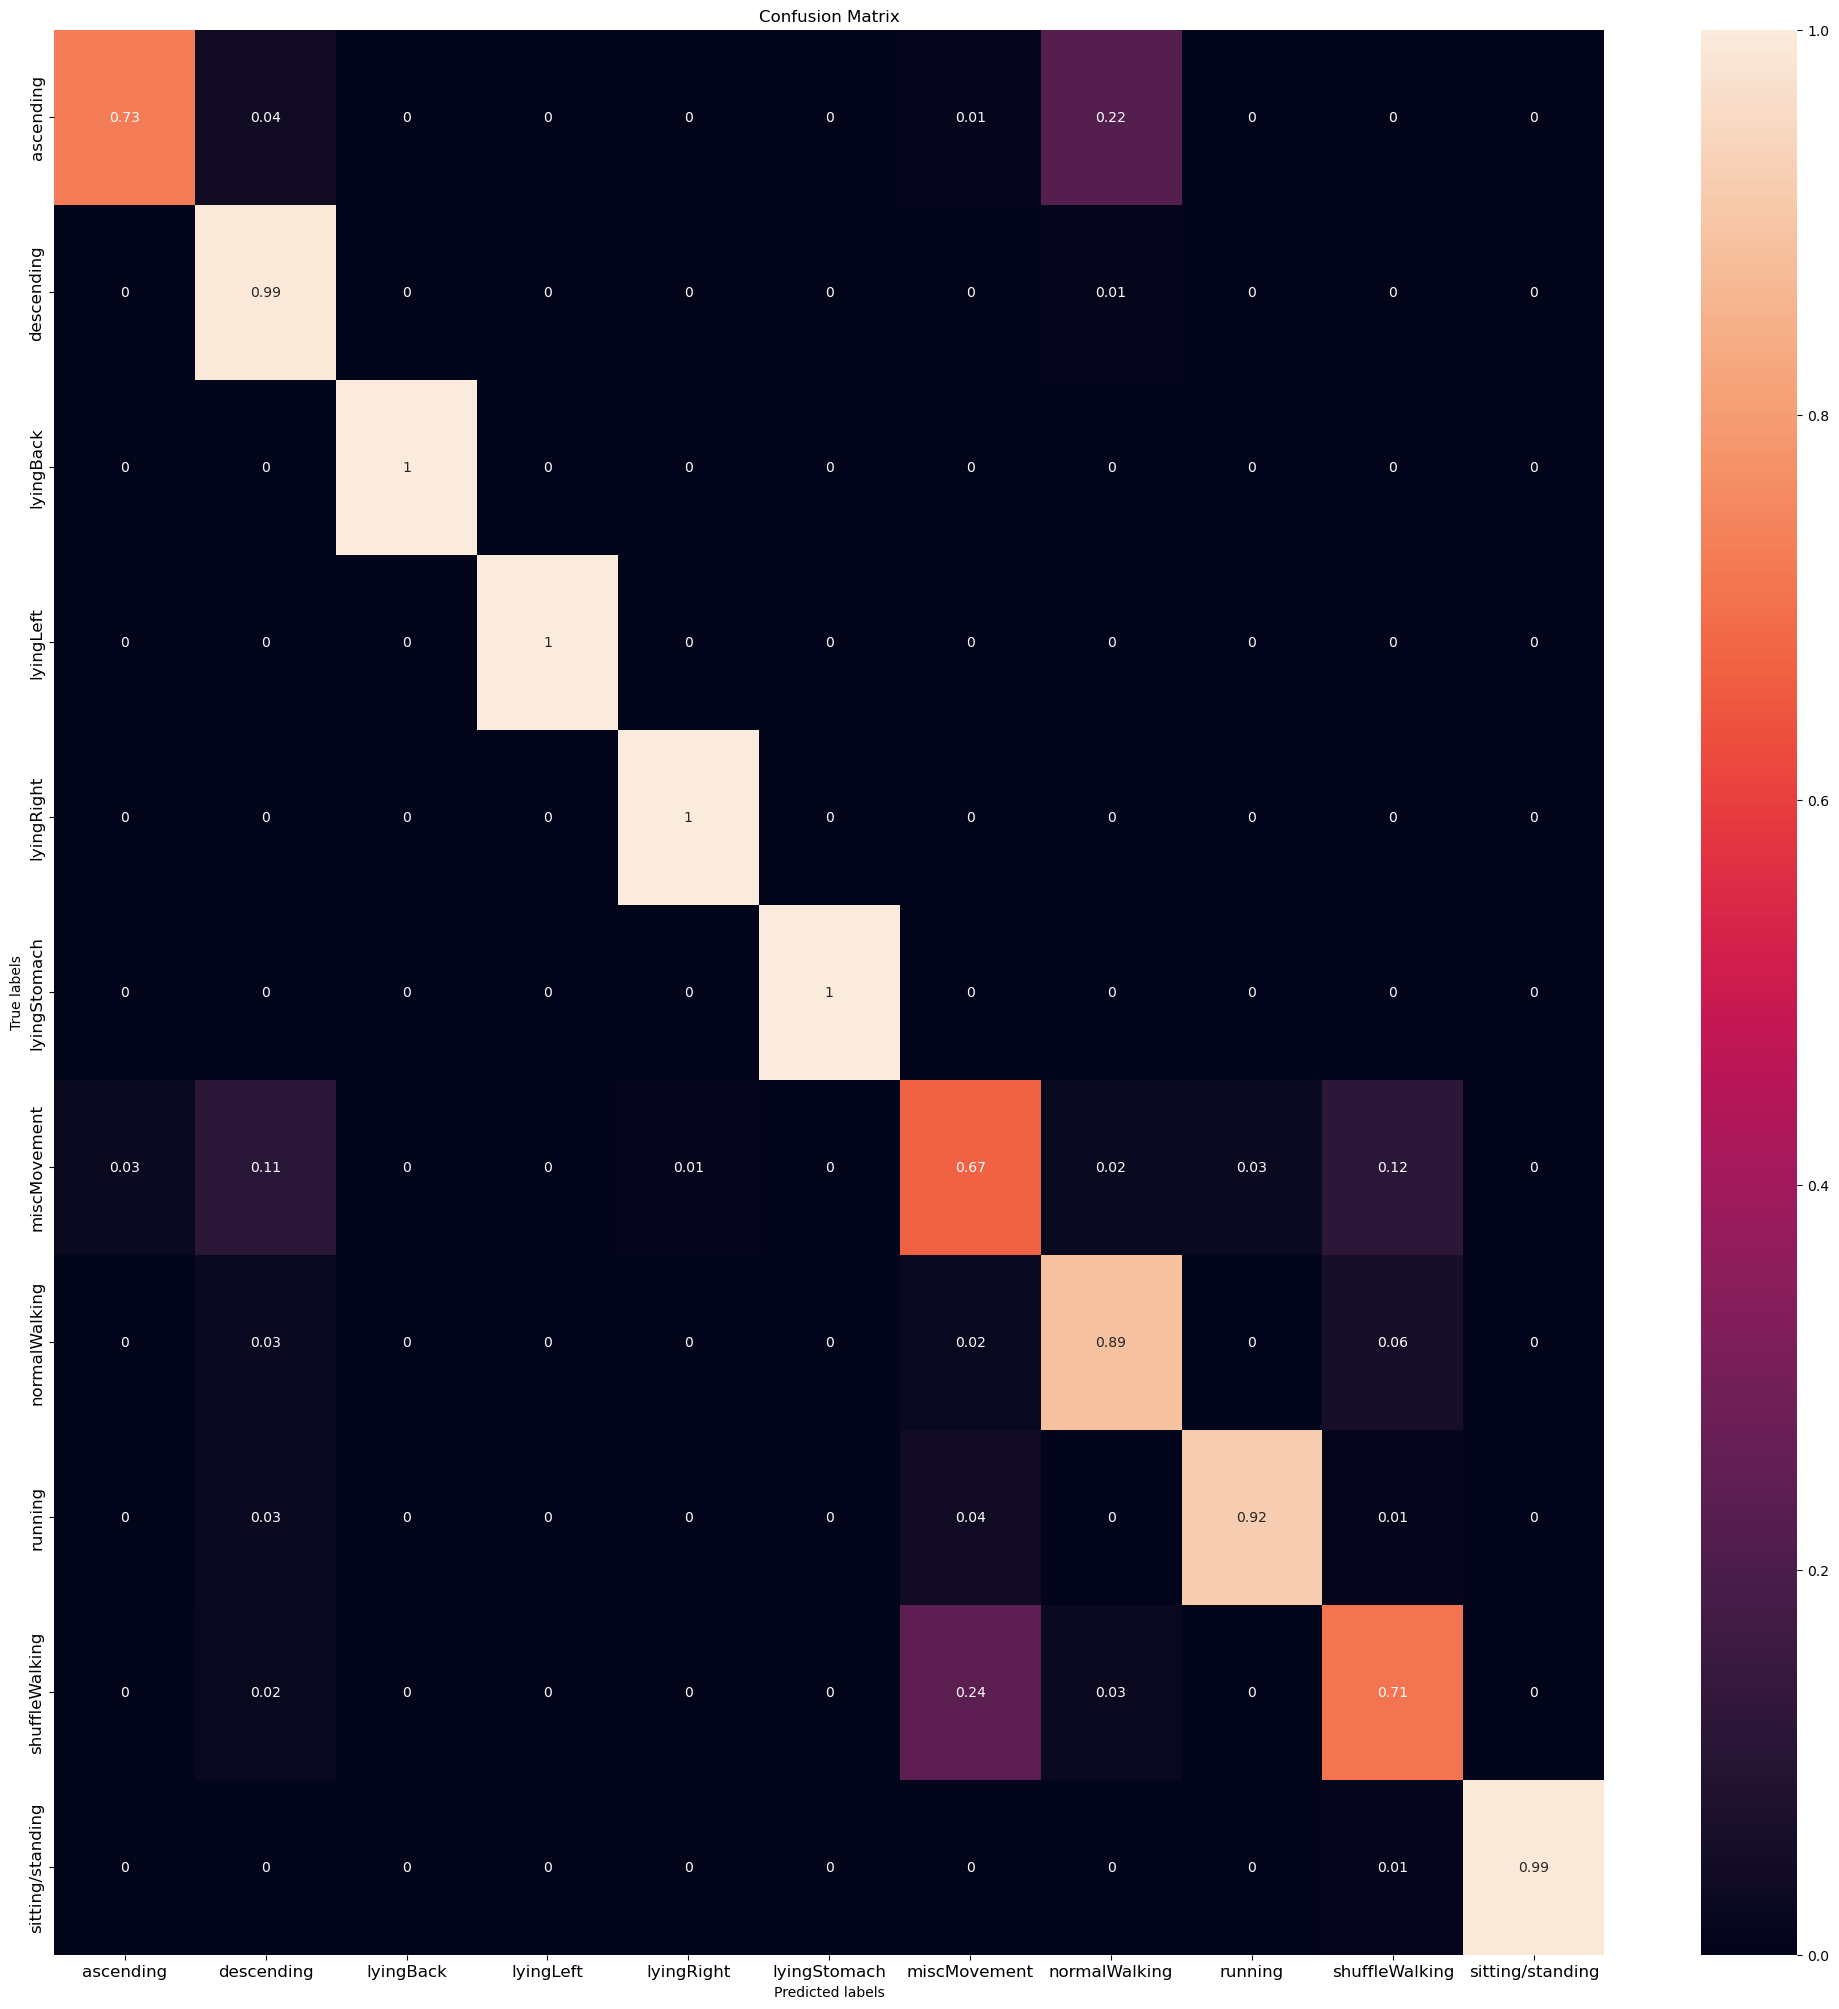

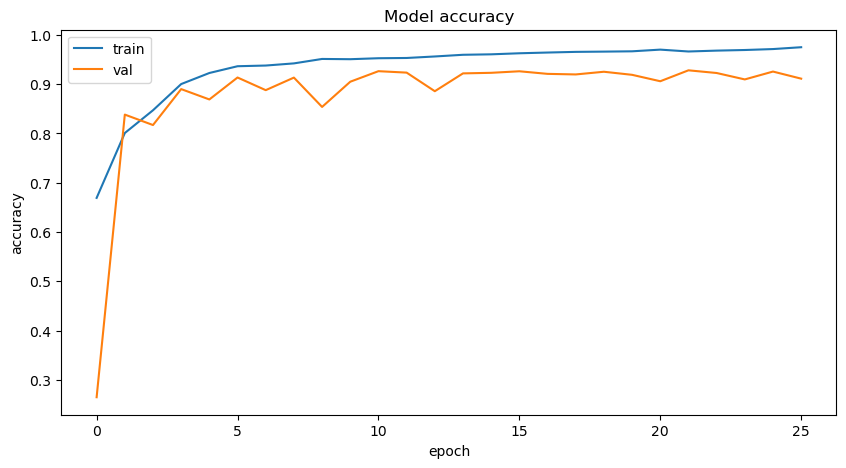

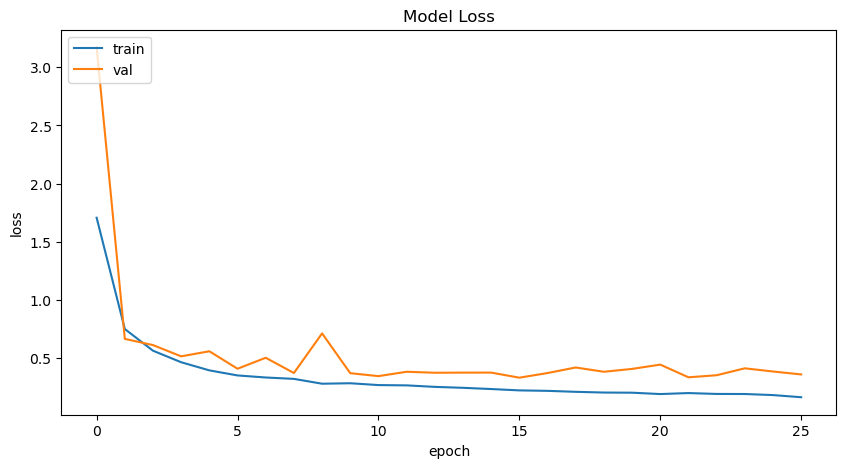

In [401]:
show_report(Conv_LSTM_model_v1, Conv_LSTM_model_v1_history)

## Bidirectional LSTM

### Bidirectional LSTM Model v1 Training
Test accuracy: 80%

In [48]:
def BiLSTM_model_v1(window_size, n_features, n_classes):
    model = Sequential()
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(200, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), 
                            input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(BatchNormalization())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics = ['accuracy'])
    
    print(model.summary())
    return model

In [49]:
print(f"Training on BiLSTM Model v1:")

window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = len(class_labels)

BiLSTM_model_v1 = BiLSTM_model_v1(window_size, n_features, n_classes)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

callbacks_list = [early_stopping, reduce_lr]

BiLSTM_model_v1_history = BiLSTM_model_v1.fit(
    X_train, y_train,
    batch_size=64, 
    epochs=30, 
    callbacks=callbacks_list,
    validation_data=(X_test, y_test))

test_loss, test_accuracy = BiLSTM_model_v1.evaluate(X_test, y_test)

print(f'Test accuracy: {test_accuracy *100:.2f}%%')

Training on BiLSTM Model v1:
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 50, 400)          331200    
 l)                                                              
                                                                 
 batch_normalization_7 (Batc  (None, 50, 400)          1600      
 hNormalization)                                                 
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              400800    
 nal)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)        